# Capstone Project
## Magic Cards for Investors
*by Liz Alvarez*

### Abstract
This project focuses on cards in the collectible card game, Magic the Gathering.  The big question is "which cards are the best?" which will be answered from the investor's perpective (with a look at the player's perspective in a potential future project).  For the investor, "best" means "which cards are worth the most?" It's easy enough to look up prices of cards and figure out which one is currently worth the most (mint condition beta Black Lotus: $100,000).  The aim of this project is not to do simple research about current card prices, however, but to predict which cards will be worth the most from newly released sets.  

The raw data was cleaned and processed with particular attention being paid to the colors in the cost of the card and the words in the card's text.  There's an abundance of data available for each card and, to avoid the curse of dimensionality, several pieces of data were binned into four groups based on their median prices.  After that, an XGBoost model was created, validated and improved with a gridsearch before being applied to a test set.  Based on the model, card prices are most affected by age of the card and converted Mana cost.  Cards that are reserved (i.e. they won't be printed again) are also worth more.  Therefore, if you're looking to invest in Magic cards, keep an eye out for old cards with a high converted Mana cost.  If you're looking to buy new cards, keep the Mana cost in mind as well as the particular words that are in the card's text and the formats in which a card is legal.  All of those things contribute to a higher value.

### Prerequisites

In this section, I'll import the necessary libraries and define all of the custome functions used in the project.

In [1]:
# importing the necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
from sklearn.model_selection import train_test_split,GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
from nltk.tokenize import MWETokenizer
import string
import re
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,mean_squared_error,explained_variance_score

In [2]:
# defining necessary functions
def colorCost(card):
    """Takes the mana cost for a given card and converts it from a string to a dictionary.
    card = the index for a card.
    returns dictionary of colors in the card's cost"""
    
    colors={'card':card,'card_name':cards_df.name[card],'any_color':0,'white':0,'blue':0,'black':0,'red':0,'green':0,'phyrexian':0,'no_color':0,'snow':0}
    if cards_df.manaCost[card] is None:
        return colors
    cost=cards_df.manaCost[card].replace('{',' ')
    cost=cost.replace('}',' ')
    cost=cost.replace('/',' ')
    cost=cost.split(' ')
    cost=[i.strip() for i in cost if i not in ['/',' ','']]
    for item in cost:
        if item=='HW': #Had to include this because of the card "Little Girl that is worth 0.5 of a white mana"
            colors['white']+=0.5
        elif item=='W':
            colors['white']+=1
        elif item=='U':
            colors['blue']+=1
        elif item=='B':
            colors['black']+=1
        elif item=='R':
            colors['red']+=1
        elif item=='G':
            colors['green']+=1
        elif item=='C':
            colors['no_color']+=1
        elif item=='S':
            colors['snow']+=1
        elif item=='P':
            colors['phyrexian']+=1
        elif item=='X' or item=='Y' or item=='Z':
            colors['any_color']+=0
        else:
            colors['any_color']+=int(item)
    return colors

def colorCostFromUrl(card_index,meta):
    """Uses the meta data from a website to determine the color cost of a card
    meta = string.
    returns dictionary of colors"""
    card_name=weird_card_urls.card[card_index]
    colors={'card_name':card_name,'any_color':0,'white':0,'blue':0,'black':0,'red':0,'green':0,'phyrexian':0,'no_color':0,'snow':0}
    cost=meta[0].replace('{',' ')
    cost=cost.replace('}',' ')
    cost=cost.replace('//',' ')
    cost=cost.replace('/',' ')
    cost=cost.split(' ')
    cost=[i.strip() for i in cost if i not in ['/',' ','']]
    for item in cost:
        if item=='W':
            colors['white']+=1
        elif item=='U':
            colors['blue']+=1
        elif item=='B':
            colors['black']+=1
        elif item=='R':
            colors['red']+=1
        elif item=='G':
            colors['green']+=1
        elif item=='C':
            colors['no_color']+=1
        elif item=='S':
            colors['snow']+=1
        elif item=='P':
            colors['phyrexian']+=1
        elif item=='X' or item=='Y' or item=='Z':
            colors['any_color']+=0
        else:
            colors['any_color']+=int(item)
    return colors

def getManaCost(card_index):
    """Scrapes scryfall.com to get the mana cost for the given card.
    card = the index of the card in the weird_cards_url dataframe.
    returns dictionary of colors"""
    html_page = requests.get(weird_card_urls.url[card_index]) # Make a get request to retrieve the page
    soup = BeautifulSoup(html_page.content, 'html.parser')
    meta = soup.find('meta',attrs={'name': 'description'})['content']
    meta=meta.split('•')
    colors=colorCostFromUrl(card_index,meta)
    return colors

def quantileSort(feature):
    """Finds the median price for each category in the given feature 
    and then splits the feature into 4 different groups based on the quartiles for the median prices."""
    features=train_df[feature].unique()
    stats=[]
    for category in features:
        prices=train_df.loc[train_df[feature]==category]['price']
        stats.append((category,prices.median()))
    stats=sorted(stats,key=lambda x:x[1])
    stats=[x for x in stats if x[0] is not None]
    medians=np.array([x[1] for x in stats])
    feature_q1=np.quantile(medians,0.25)
    feature_q2=np.median(medians)
    feature_q3=np.quantile(medians,0.75)
    q1=[]
    q2=[]
    q3=[]
    q4=[]
    for stat in stats:
        if stat[1]<feature_q1:
            q1.append(stat[0])
        elif stat[1]<feature_q2:
            q2.append(stat[0])
        elif stat[1]<feature_q3:
            q3.append(stat[0])
        else:
            q4.append(stat[0])
    return q1,q2,q3,q4

def encoder(feature,groups):
    """Takes in a given feature and the four quartile groups.  One-hot encodes the feature, adds those columns
    to the original dataframe, drops the original feature column.  Feature is the column name. Groups is a list 
    of the lists of quartile categories."""
    feature_df=X_train[[feature]].copy()
    feature_df[feature+'_Group']=['Q1_'+feature if feature_df[feature][x] in groups[0]
                         else 'Q2_'+feature if feature_df[feature][x] in groups[1]
                         else 'Q3_'+feature if feature_df[feature][x] in groups[2]
                         else 'Q4_'+feature for x in feature_df.index]
    ohe_df=pd.get_dummies(feature_df[feature+"_Group"])
    feature_df=feature_df.join(ohe_df)
    feature_df.drop([feature,feature+'_Group'],axis=1,inplace=True)                                    
    return feature_df

def median_price(word):
    """Find the median price of cards with text that contains the given word. Returns the median price."""
    # this is a very slow way to get all the median prices.  The next method is much quicker.
    prices=[]
    for x in card_text.index:
        if word in card_text.token_text[x]:
            prices.append(card_text.price[x])
        else:
            continue
    return np.median(prices)

def magic_tokens(text):
    """Tokenizes the text of a Magic card.  Groups Magic phrases together.  Returns list of words from card text."""
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    stopwords_list += ["''", '""', '...', '``']
    stopwords_list += ['w','b','u','r','g','c','s','p','x','y','z']
    stopwords_list.remove('t')
    magic_tokenizer = MWETokenizer(magic_phrases_tokenized)
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    raw_text = nltk.regexp_tokenize(text, pattern)
    raw_text = magic_tokenizer.tokenize(raw_text)
    raw_text = [x.lower() for x in raw_text if x!='None']
    card_text = [x for x in raw_text if x not in stopwords_list]
    return card_text

def find_word_prices(card):
    """Finds all the prices from cards that feature the given word. Returns a list of prices."""
    for word in list(set(card_text.token_text[card])):
        if word in all_word_prices.keys():
            all_word_prices[word].append(card_text.price[card])
        else:
            all_word_prices[word]=[card_text.price[card]]
    return all_word_prices

def word_quantiles(card):
    """Replaces words in the card's text with its corresponding quantile. (A quantile is based on the median price of cards
    with that word in its text.)  Returns the quantile-ified text"""
    new_text=[word_quantiles_dict[x] for x in list(set(card_text['token_text'][card]))]
    return new_text

def preprocess_ohe_feature(feature,feature_group,df):
    """Takes in a feature, the items for the feature split into 4 quartile groups based on the training dataset, and
    a dataframe.  One-hot-encodes the given dataframe for the given feature into the given quartile groups. Returns
    the updated dataframe."""
    feature_df=df[['uuid',feature]].copy()
    feature_df[feature+'_group']=['Q1_'+feature if feature_df[feature][x] in feature_group[0]
                                 else 'Q2_'+feature if feature_df[feature][x] in feature_group[1]
                                 else 'Q3_'+feature if feature_df[feature][x] in feature_group[2]
                                 else 'Q4_'+feature if feature_df[feature][x] in feature_group[3]
                                 else None for x in feature_df.index]
    feature_ohe=pd.get_dummies(feature_df[feature+'_group'])
    processed_df=df.join(feature_ohe,rsuffix='wrong')
    return processed_df

def preprocess_ohe(features,feature_groups,df):
    """Takes in a list of features, their corresponding quartile groups and a dataframe.  One-hot-encodes the given
    dataframe for each of the given features into the given quartile groups.  Returns the update dataframe."""
    processed_df=df
    for i in range(len(features)):
        feature=features[i]
        feature_group=feature_groups[i]
        processed_df=preprocess_ohe_feature(feature,feature_group,processed_df)
    return processed_df

def preprocess_tokenize(df):
    """Takes in a dataframe and transforms the text from each card into counts of word quartiles."""
    card_text=df[['uuid','name','allText']].copy()
    card_text['token_text']=[magic_tokens(str(card_text.allText[x])) for x in card_text.index]
    card_text.drop('allText',axis=1,inplace=True)
    q1_words=[]
    q2_words=[]
    q3_words=[]
    q4_words=[]
    for card in card_text.index:
        new_text=[]
        for word in list(set(card_text['token_text'][card])):
            if word in word_quantiles_dict.keys():
                new_text.append(word_quantiles_dict[word])
            else:
                continue
        q1_words.append(new_text.count('q1'))
        q2_words.append(new_text.count('q2'))
        q3_words.append(new_text.count('q3'))
        q4_words.append(new_text.count('q4'))
    card_text['q1_words']=q1_words
    card_text['q2_words']=q2_words
    card_text['q3_words']=q3_words
    card_text['q4_words']=q4_words
    card_text.drop(['name','token_text','uuid'],axis=1,inplace=True)
    processed_df=df.join(card_text)
    return processed_df

## Obtaining Data

In this section, I'll get all of the data I need from a variety of resources (but primarily an SQL database from the site MTGJSON).

In [3]:
# creating a connection to the SQL database and a cursor object
conn = sqlite3.Connection('AllPrintings.sqlite')
c = conn.cursor()

In [4]:
# examining the database to see what tables are present
c.execute("""SELECT *
            FROM sqlite_master
            WHERE type='table'""")
tables=c.fetchall()
for table in tables:
    print(table[1])

sets
sqlite_sequence
cards
tokens
prices
rulings
legalities
foreign_data
set_translations


Now that I know what tables are present, I'd like to see what the primary keys are for each table as well as what other data is available in each table.  First, I'll find the primary keys.

In [5]:
# getting primary keys for each table
c.execute("""SELECT sql
            FROM sqlite_master
            WHERE type='table'""")
df=pd.DataFrame(c.fetchall())
df.columns=[x[0] for x in c.description]
for i in range(len(df)):
    print(df.sql[i][:65])
    print('\n')

CREATE TABLE `sets` (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
 


CREATE TABLE sqlite_sequence(name,seq)


CREATE TABLE `cards` (
    id INTEGER PRIMARY KEY AUTOINCREMENT,



CREATE TABLE `tokens` (
    id INTEGER PRIMARY KEY AUTOINCREMENT,


CREATE TABLE `prices` (
    id INTEGER PRIMARY KEY AUTOINCREMENT,


CREATE TABLE `rulings` (
    id INTEGER PRIMARY KEY AUTOINCREMENT


CREATE TABLE `legalities` (
    id INTEGER PRIMARY KEY AUTOINCREM


CREATE TABLE `foreign_data` (
    id INTEGER PRIMARY KEY AUTOINCR


CREATE TABLE `set_translations` (
    id INTEGER PRIMARY KEY AUTO




The primary keys are all just auto-indexes so that might not be the most useful way to join tables.  I'm guessing there's a better column to join data on but I'll need all of the keys for the tables to figure that out.

In [6]:
# exploring the structure of the SQL database
for table in tables:
    name=table[1]
    c.execute("""SELECT *
                 from {}""".format(name))
    columns=[x[0] for x in c.description]
    print(f'Table: {name}\nColumns: {columns}\n')

Table: sets
Columns: ['id', 'baseSetSize', 'block', 'boosterV3', 'code', 'codeV3', 'isFoilOnly', 'isForeignOnly', 'isOnlineOnly', 'isPartialPreview', 'keyruneCode', 'mcmId', 'mcmName', 'meta', 'mtgoCode', 'name', 'parentCode', 'releaseDate', 'tcgplayerGroupId', 'totalSetSize', 'type']

Table: sqlite_sequence
Columns: ['name', 'seq']

Table: cards
Columns: ['id', 'artist', 'asciiName', 'borderColor', 'colorIdentity', 'colorIndicator', 'colors', 'convertedManaCost', 'duelDeck', 'edhrecRank', 'faceConvertedManaCost', 'flavorName', 'flavorText', 'frameEffect', 'frameEffects', 'frameVersion', 'hand', 'hasFoil', 'hasNoDeckLimit', 'hasNonFoil', 'isAlternative', 'isArena', 'isBuyABox', 'isDateStamped', 'isFullArt', 'isMtgo', 'isOnlineOnly', 'isOversized', 'isPaper', 'isPromo', 'isReprint', 'isReserved', 'isStarter', 'isStorySpotlight', 'isTextless', 'isTimeshifted', 'layout', 'leadershipSkills', 'life', 'loyalty', 'manaCost', 'mcmId', 'mcmMetaId', 'mtgArenaId', 'mtgoFoilId', 'mtgoId', 'multive

So, that's useful information but in a difficult to parse format.  Here's an easier-to-read representation of the SQL database:

<center><img src='images/AllCardsSQL.png'></center>

First, I'm going to gather all the data I'll need to be able to predict a card's price.  I'm going to grab things that I think will affect the price (such as the text and artist) and leave out things that are extremely likely to make no difference (like the rulings).  It looks like each card has a unique `uuid` entry so I'll join the tables on that.

In [7]:
# getting all of the columns that might be important for determining price and turning it into a dataframe
c.execute("""SELECT c.uuid, c.name,c.names, c.artist, c.borderColor,
                    c.colors,c.convertedManaCost,c.flavorText,c.frameEffects,
                    c.frameVersion,c.isAlternative,c.isDateStamped,c.isFullArt,
                    c.isPromo,c.isReserved,c.isTimeShifted,c.layout,c.manaCost,
                    c.power,c.rarity,c.subtypes,c.supertypes,c.text,c.originalText,
                    c.toughness,c.type,c.types,s.name as setName,s.releaseDate,
                    l.format,l.status,p.date as priceDate,p.type as priceType,p.price
            FROM cards as c
            JOIN sets as s 
            ON s.code = c.setCode
            JOIN legalities as l
            on l.uuid = c.uuid
            JOIN prices as p
            ON p.uuid = c.uuid
            WHERE priceType='paper' or priceType='paperFoil'""")
cards_df=pd.DataFrame(c.fetchall())
cards_df.columns=[x[0] for x in c.description]
cards_df.head()

,uuid,name,names,artist,borderColor,colors,convertedManaCost,flavorText,frameEffects,frameVersion,...,toughness,type,types,setName,releaseDate,format,status,priceDate,priceType,price
0,1669af17-d287-5094-b005-4b143441442f,Abundance,None,Rebecca Guay,black,G,4.0,None,None,2003,...,None,Enchantment,Enchantment,Tenth Edition,2007-07-13,commander,Legal,2020-04-26,paper,1.31
1,1669af17-d287-5094-b005-4b143441442f,Abundance,None,Rebecca Guay,black,G,4.0,None,None,2003,...,None,Enchantment,Enchantment,Tenth Edition,2007-07-13,duel,Legal,2020-04-26,paper,1.31
2,1669af17-d287-5094-b005-4b143441442f,Abundance,None,Rebecca Guay,black,G,4.0,None,None,2003,...,None,Enchantment,Enchantment,Tenth Edition,2007-07-13,legacy,Legal,2020-04-26,paper,1.31
3,1669af17-d287-5094-b005-4b143441442f,Abundance,None,Rebecca Guay,black,G,4.0,None,None,2003,...,None,Enchantment,Enchantment,Tenth Edition,2007-07-13,modern,Legal,2020-04-26,paper,1.31
4,1669af17-d287-5094-b005-4b143441442f,Abundance,None,Rebecca Guay,black,G,4.0,None,None,2003,...,None,Enchantment,Enchantment,Tenth Edition,2007-07-13,vintage,Legal,2020-04-26,paper,1.31


I'll just be looking at cards (and not tokens) in this project since tokens are not as valuable as cards, with very few exceptions.  In future work, I may also look at tokens but it's likely they'll have a different set of important features than regular cards do (so tokens will probably require a different, separate model).

### Scrubbing the Data

In this section, I'm going to clean the data.  And, oh boy, is there a lot of cleaning to do.  First, I'm just going to take a look at all of the data available for one random card.

In [8]:
# just checking out all of the features of one of the cards
for feature in cards_df.columns:
    print(f'{feature.title()}: {cards_df[feature][51443]}')

Uuid: 2752c5f3-b438-5696-bf6d-dfa35b1be159
Name: Death Wind
Names: None
Artist: Tomasz Jedruszek
Bordercolor: black
Colors: B
Convertedmanacost: 1.0
Flavortext: Leukin stared at the smoldering angel feathers. "Run!" he screamed to his patrol. "We don't stand a chance!"
Frameeffects: None
Frameversion: 2003
Isalternative: 0
Isdatestamped: 0
Isfullart: 0
Ispromo: 0
Isreserved: 0
Istimeshifted: 0
Layout: normal
Manacost: {X}{B}
Power: None
Rarity: common
Subtypes: None
Supertypes: None
Text: Target creature gets -X/-X until end of turn.
Originaltext: Target creature gets -X/-X until end of turn.
Toughness: None
Type: Instant
Types: Instant
Setname: Avacyn Restored
Releasedate: 2012-05-04
Format: vintage
Status: Legal
Pricedate: 2020-04-26
Pricetype: paper
Price: 0.14


Next, I want to check out the dataframe to see how many values and what type of data I'm dealing with.

In [9]:
# checking out the column info
cards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431739 entries, 0 to 431738
Data columns (total 34 columns):
uuid                 431739 non-null object
name                 431739 non-null object
names                5135 non-null object
artist               431739 non-null object
borderColor          431739 non-null object
colors               337923 non-null object
convertedManaCost    431739 non-null float64
flavorText           263668 non-null object
frameEffects         18900 non-null object
frameVersion         431739 non-null object
isAlternative        431739 non-null int64
isDateStamped        431739 non-null int64
isFullArt            431739 non-null int64
isPromo              431739 non-null int64
isReserved           431739 non-null int64
isTimeshifted        431739 non-null int64
layout               431739 non-null object
manaCost             374220 non-null object
power                202417 non-null object
rarity               431739 non-null object
subtypes         

There are a lot of non-numerical columns to deal with so I'll take things one column at a time.  

The first thing I'm going to do is fix the format column.  The first five cards are actually the same card that's legal in five different formats.  So, I need to combine all of those into one row and add different columns (one for each format).  In other words I'm going to go from:
<table>
    <tr><td><center><b>Card Name</b></center></td><td><center><b>Other Columns</b></center></td><td><center><b>Format</b></center></td><td><b>Status</b></td></tr>
    <tr><td><center>Abundance</center></td><td><center>...</center></td><td><center>Commander</center></td><td>Legal</td></tr>
    <tr><td><center>Abundance</center></td><td><center>...</center></td><td><center>Duel</center></td><td>Legal</td></tr>
    <tr><td><center>Abundance</center></td><td><center>...</center></td><td><center>Legacy</center></td><td>Legal</td></tr>
    <tr><td><center>Abundance</center></td><td><center>...</center></td><td><center>Modern</center></td><td>Legal</td></tr>
    <tr><td><center>Abundance</center></td><td><center>...</center></td><td><center>Vintage</center></td><td>Legal</td></tr>
</table>

To:
<table>
    <tr><td><center><b>Card Name</b></center></td><td><center><b>Other Columns</b></center></td><td><center><b>Format_Commander</b></center></td><td><center><b>Format_Duel</b></center></td><td><center><b>Format_Legacy</b></center></td><td><center><b>Format_Modern</b></center></td><td><center><b>Format_Vintage</b></center></td></tr>
    <tr><td>Abundance</td><td><center>...</center></td><td><center>1</center></td><td><center>1</center></td><td><center>1</center></td><td><center>1</center></td><td><center>1</center></td></tr>
</table>

Everything is exactly the same for those five rows except for the format and status so that makes it a lot easier to combine them.  First, however, I need to split the dataframe into paper cards and foil cards (because the paper versions and the foil versions of the cards have the same `uuid` so the pivot function would give an error for duplicate entries). And, actually, whether it's foil or not won't affect which formats a card is legal in so I don't really need both sets.

In [10]:
# making a dataframe of just the paper cards
paper_df=cards_df.loc[cards_df.priceType=="paper"].copy()

In [11]:
# pivoting the paper cards dataframe
paper_formats_df=paper_df.pivot(index='uuid',columns='format',values='status')

In [12]:
# looking at the top of the pivoted paper cards dataframe to make sure the format is correct
paper_formats_df.head()

format,brawl,commander,duel,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
uuid,,,,,,,,,,,,,
00028782-6ec2-54fe-8633-2c906d8f1076,NaN,Legal,Legal,NaN,NaN,Legal,NaN,NaN,Legal,NaN,NaN,NaN,Legal
00040b50-3b84-5cea-b663-70038b87fa08,NaN,Legal,Legal,NaN,NaN,Legal,Legal,NaN,NaN,Legal,NaN,NaN,Legal
0005e7e7-fe15-5acb-89aa-adacf0481952,NaN,Legal,Legal,NaN,NaN,Legal,Legal,NaN,Legal,Legal,NaN,NaN,Legal
00087aa5-4199-58ba-8e06-7acb796060cb,NaN,Legal,Legal,NaN,NaN,Legal,Legal,NaN,NaN,Legal,Legal,NaN,Legal
0008b776-44af-5d76-835b-692458848052,NaN,Legal,Legal,NaN,NaN,Legal,Legal,NaN,Legal,Legal,NaN,NaN,Legal


In [13]:
# changing the format legalities from "Legal" to 1 and "NaN" to 0
formats=paper_formats_df.columns
for form in formats:
    paper_formats_df[form]=[1 if paper_formats_df[form][x]=='Legal' else 0 for x in paper_formats_df.index]
paper_formats_df.head()

format,brawl,commander,duel,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
uuid,,,,,,,,,,,,,
00028782-6ec2-54fe-8633-2c906d8f1076,0,1,1,0,0,1,0,0,1,0,0,0,1
00040b50-3b84-5cea-b663-70038b87fa08,0,1,1,0,0,1,1,0,0,1,0,0,1
0005e7e7-fe15-5acb-89aa-adacf0481952,0,1,1,0,0,1,1,0,1,1,0,0,1
00087aa5-4199-58ba-8e06-7acb796060cb,0,1,1,0,0,1,1,0,0,1,1,0,1
0008b776-44af-5d76-835b-692458848052,0,1,1,0,0,1,1,0,1,1,0,0,1


Now, I'll combine that back in with the rest of the data to make one dataframe with all the info.

In [14]:
# dropping the extra columns from my original dataframe
cards_df.drop(['format','status'],axis=1,inplace=True)
cards_df.drop_duplicates(keep='first', inplace=True)
cards_df.head()

,uuid,name,names,artist,borderColor,colors,convertedManaCost,flavorText,frameEffects,frameVersion,...,text,originalText,toughness,type,types,setName,releaseDate,priceDate,priceType,price
0,1669af17-d287-5094-b005-4b143441442f,Abundance,None,Rebecca Guay,black,G,4.0,None,None,2003,...,"If you would draw a card, you may instead choo...","If you would draw a card, you may instead choo...",None,Enchantment,Enchantment,Tenth Edition,2007-07-13,2020-04-26,paper,1.31
5,1669af17-d287-5094-b005-4b143441442f,Abundance,None,Rebecca Guay,black,G,4.0,None,None,2003,...,"If you would draw a card, you may instead choo...","If you would draw a card, you may instead choo...",None,Enchantment,Enchantment,Tenth Edition,2007-07-13,2020-04-26,paperFoil,33.03
10,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,None,Stephen Daniele,black,U,3.0,They brandish their latest theories as warrior...,None,2003,...,When Academy Researchers enters the battlefiel...,"When Academy Researchers comes into play, you ...",2,Creature — Human Wizard,Creature,Tenth Edition,2007-07-13,2020-04-26,paper,0.36
15,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,None,Stephen Daniele,black,U,3.0,They brandish their latest theories as warrior...,None,2003,...,When Academy Researchers enters the battlefiel...,"When Academy Researchers comes into play, you ...",2,Creature — Human Wizard,Creature,Tenth Edition,2007-07-13,2020-04-26,paperFoil,2.69
20,ee19938c-4007-58f1-8904-fae28007b422,Adarkar Wastes,None,John Avon,black,None,0.0,None,None,2003,...,{T}: Add {C}.\n{T}: Add {W} or {U}. Adarkar Wa...,{T}: Add {1} to your mana pool.\n{T}: Add {W} ...,None,Land,Land,Tenth Edition,2007-07-13,2020-04-26,paper,10.84


In [15]:
# merging the format dataframe back in with the original dataframe
cards_df=pd.merge(cards_df,paper_formats_df,left_on='uuid',right_on='uuid')
cards_df.head()

,uuid,name,names,artist,borderColor,colors,convertedManaCost,flavorText,frameEffects,frameVersion,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
0,1669af17-d287-5094-b005-4b143441442f,Abundance,None,Rebecca Guay,black,G,4.0,None,None,2003,...,0,0,1,1,0,0,0,0,0,1
1,1669af17-d287-5094-b005-4b143441442f,Abundance,None,Rebecca Guay,black,G,4.0,None,None,2003,...,0,0,1,1,0,0,0,0,0,1
2,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,None,Stephen Daniele,black,U,3.0,They brandish their latest theories as warrior...,None,2003,...,0,0,1,1,0,0,0,0,0,1
3,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,None,Stephen Daniele,black,U,3.0,They brandish their latest theories as warrior...,None,2003,...,0,0,1,1,0,0,0,0,0,1
4,ee19938c-4007-58f1-8904-fae28007b422,Adarkar Wastes,None,John Avon,black,None,0.0,None,None,2003,...,0,0,1,1,0,0,0,0,0,1


The next thing I'm going to do is fix the names for the cards.  Right now, there are two columns (`name` and `names`) that both describe what a card is called.  If a card is just a normal, single-faced card, it only has a `name` but if the card is split or aftermath, it is generally referred to by both names so I'll keep the `names` entry instead for those cards.

<table>
    <tr><td><img src="images/commit-memory.jpg" width='300'/></td><td><img src="images/fire-ice.jpg" width='300'/></td><td><img src="images/who-what-when-where-why.jpg" width='300'/></td></tr>
    <tr><td><center><i>An aftermath card called Commit Memory</i></center></td><td><center><i>A split card called Fire Ice</i></center></td><td><center><i>The most split card ever: Who What When Where Why</i></center></td></tr></table>

In [16]:
#finding all the cards with layouts that are either split or aftermath and updating the name column
split_aftermath_cards=cards_df.loc[(cards_df.layout=='split')|(cards_df.layout=='aftermath')].index
for card in split_aftermath_cards:
    cards_df.name[card]=cards_df.names[card]

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
#dropping the names column
cards_df.drop('names',axis=1,inplace=True)

Ok, the `name`/`names` issue is dealt with.  

There are a lot of things I need to do to get this dataset ready but one of the easiest things is to drop all of the cards in the Ikoria set.  It has just been released on paper so its prices haven't had a chance to really stabilize yet.  There's also a major recent rule change that added some of its cards (the companion cards) to the banned list for all formats.  So that will also definitely change some card prices in Ikoria.  (At the end of this project, however, I'm going to take a look at Ikoria cards again to see which cards will be most valuable as predicted by my model.)

In [18]:
#getting the indices of all the Ikoria cards and then dropping them from the dataframe
ikoria_cards=cards_df.loc[cards_df.setName=='Ikoria: Lair of Behemoths'].index
cards_df.drop(ikoria_cards,axis=0,inplace=True)

In [19]:
#checking to make sure the cards were dropped
cards_df.loc[cards_df.setName=='Ikoria: Lair of Behemoths'].head()

,uuid,name,artist,borderColor,colors,convertedManaCost,flavorText,frameEffects,frameVersion,isAlternative,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage


Next up, I'm going to do a first pass over the text of the cards.  I can't really delve into the text until after I split out my training/test sets but I can do a quick look at the text.  

There are two columns, `text` and `originalText` for each card.  If the layout is normal (not split or aftermath, basically), then the text and original text should be the same.  But let's take a look at a split card, Fire Ice (pictured above).

In [20]:
#comparing the text and original text for a card with a split layout
print('Text:')
print(cards_df.text[6821])
print('---------\nOriginal Text:')
print(cards_df.originalText[6821])

Text:
Fire deals 2 damage divided as you choose among one or two targets.
---------
Original Text:
Tap target permanent.
Draw a card.


The `originalText` column has the text for the second part of the card (Ice) whereas the `text` column only has the text from the first part of the card (Fire).  If the card is a normal layout, `text` and `originalText` are the same.  

To clean up these columns, I'll compare `text` and `originalText` to see if they're the same.  If they are, it doesn't matter which one I keep so I'll just choose one.  If they're different, I'll concatenate them and keep both.

In [21]:
#comparing text and originalText to see which one to keep
cards_df['allText']=[cards_df.text[x] if cards_df.text[x]==cards_df.originalText[x] 
                     else (str(cards_df.text[x])+' '+str(cards_df.originalText[x])) for x in cards_df.index]

In [22]:
#checking the top of the dataframe to make sure it worked alright
cards_df.loc[cards_df.layout=='split'][['text','originalText','allText']].head()

,text,originalText,allText
6821,Fire deals 2 damage divided as you choose amon...,Tap target permanent.\nDraw a card.,Fire deals 2 damage divided as you choose amon...
6822,Fire deals 2 damage divided as you choose amon...,Tap target permanent.\nDraw a card.,Fire deals 2 damage divided as you choose amon...
6857,Target spell or permanent becomes the color of...,Destroy target artifact.,Target spell or permanent becomes the color of...
6858,Target spell or permanent becomes the color of...,Destroy target artifact.,Target spell or permanent becomes the color of...
6881,All lands you control become 1/1 creatures unt...,Return target creature card from your graveyar...,All lands you control become 1/1 creatures unt...


Looks pretty good so far.  I'm going to take a look at a single card to make sure the text combined as expected.

In [23]:
#comparing the text and original text for a card with a split layout
print('Text:')
print(cards_df.text[6857])
print('---------\nOriginal Text:')
print(cards_df.originalText[6857])
print('---------\nAll Text:')
print(cards_df.allText[6857])

Text:
Target spell or permanent becomes the color of your choice until end of turn.
---------
Original Text:
Destroy target artifact.
---------
All Text:
Target spell or permanent becomes the color of your choice until end of turn. Destroy target artifact.


Exactly what I wanted.  The `allText` column has both the `text` and the `originalText` so now I can drop both of those columns.

In [24]:
#dropping the text and originalText columns
cards_df.drop(['text','originalText'],axis=1,inplace=True)

Next, I'm going to add a column for the age of the card.  I'll do that by subtracting the release date from the price date.  I'll have to turn both of those columns to date-time columns though first.

In [25]:
# Checking the type for the date columns.  They're both strings so they'll have to be changed to date-time
type(cards_df.releaseDate[0]),type(cards_df.priceDate[0])

(str, str)

In [26]:
# changing both columns to date-time and checking to make sure it worked
cards_df.releaseDate=pd.to_datetime(cards_df['releaseDate'])
cards_df.priceDate=pd.to_datetime(cards_df['priceDate'])
type(cards_df.releaseDate[0]),type(cards_df.priceDate[0])

(pandas._libs.tslibs.timestamps.Timestamp,
 pandas._libs.tslibs.timestamps.Timestamp)

Yep, they're both timestamps now so I can calculate the card age by subtracting them.

In [27]:
# calculating the card age in days for each card
cards_df['cardAge']=cards_df['priceDate']-cards_df['releaseDate']
cards_df.cardAge=[x.days for x in cards_df.cardAge]
cards_df.head()

,uuid,name,artist,borderColor,colors,convertedManaCost,flavorText,frameEffects,frameVersion,isAlternative,...,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage,allText,cardAge
0,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,black,G,4.0,None,None,2003,0,...,1,1,0,0,0,0,0,1,"If you would draw a card, you may instead choo...",4671
1,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,black,G,4.0,None,None,2003,0,...,1,1,0,0,0,0,0,1,"If you would draw a card, you may instead choo...",4671
2,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,black,U,3.0,They brandish their latest theories as warrior...,None,2003,0,...,1,1,0,0,0,0,0,1,When Academy Researchers enters the battlefiel...,4671
3,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,black,U,3.0,They brandish their latest theories as warrior...,None,2003,0,...,1,1,0,0,0,0,0,1,When Academy Researchers enters the battlefiel...,4671
4,ee19938c-4007-58f1-8904-fae28007b422,Adarkar Wastes,John Avon,black,None,0.0,None,None,2003,0,...,1,1,0,0,0,0,0,1,{T}: Add {C}.\n{T}: Add {W} or {U}. Adarkar Wa...,4671


Next, I'm going to add one column for each color that shows up on Magic cards.  There are 6 possibilities: white, black, red, blue, green, and colorless.  In each column, I'll include how many times that color shows up on the card.  For example, Coalition Victory (shown below) has 3 colorless, 1 white, 1 blue, 1 black, 1 red, and 1 green.  Dismantling Blow (also shown below) counts as 2 colorless, and 1 white.  There are a couple other random colors (snow, phyrexian, and colorless-but-with-a-diamond) that show up on some cards so I'll add columns for those, too.

<table>
    <tr><td><img src="images/coalition-victory.jpg" width='300'/></td><td><img src="images/dismantling-blow.jpg" width='300'/></td></tr>
    <tr><td><center><i>Coalition Victory</i></center></td><td><center><i>Dismantling Blow</i></center></td></tr></table>

In [28]:
#converting the manaCost from a string to separate columns for each card in the dataframe
colors=[]
for card in cards_df.index:
    colors.append(colorCost(card))
colors_df=pd.DataFrame(colors,index=[x['card'] for x in colors])
colors_df.drop('card',axis=1,inplace=True)
colors_df.tail()

,any_color,black,blue,card_name,green,no_color,phyrexian,red,snow,white
59304,3,0,0,World Queller,0,0,0,0,0,2
59305,3,0,0,World Queller,0,0,0,0,0,2
59306,1,0,0,Zektar Shrine Expedition,0,0,0,1,0,0
59307,4,0,0,Zendikar Farguide,1,0,0,0,0,0
59308,4,0,0,Zendikar Farguide,1,0,0,0,0,0


In [29]:
#comparing the color columns to the convertedManaCost. The colors should add up to the converted Mana cost
color_features=['any_color','black','blue','green','no_color','phyrexian','red','snow','white']
calculated_costs=[]

for card in colors_df.index:
    calculated_mana_cost=0
    for color in color_features:
        calculated_mana_cost+=colors_df[color][card]
    calculated_costs.append(calculated_mana_cost)

colors_df['calculatedManaCost']=calculated_costs
colors_df['manaCostComparison']=['Good' if cards_df.convertedManaCost[x]<=colors_df.calculatedManaCost[x] 
                                 else 'Bad' for x in colors_df.index]

colors_df.head()

,any_color,black,blue,card_name,green,no_color,phyrexian,red,snow,white,calculatedManaCost,manaCostComparison
0,2,0,0,Abundance,2,0,0,0,0,0,4,Good
1,2,0,0,Abundance,2,0,0,0,0,0,4,Good
2,1,0,2,Academy Researchers,0,0,0,0,0,0,3,Good
3,1,0,2,Academy Researchers,0,0,0,0,0,0,3,Good
4,0,0,0,Adarkar Wastes,0,0,0,0,0,0,0,Good


In [30]:
# checking to make sure the sum of the colors is the same as the converted Mana cost for all the cards
colors_df.manaCostComparison.value_counts()

Good    58561
Bad       192
Name: manaCostComparison, dtype: int64

For 192 of the cards, the values from the color columns don't add up to the converted Mana cost (but they should).  I'm going to check out the cards that don't add up to see what's going on.

In [31]:
colors_df.loc[colors_df.manaCostComparison=='Bad'].head(10)

,any_color,black,blue,card_name,green,no_color,phyrexian,red,snow,white,calculatedManaCost,manaCostComparison
5577,3,0,1,"Commit,Memory",0,0,0,0,0,0,4,Bad
5578,3,0,1,"Commit,Memory",0,0,0,0,0,0,4,Bad
5598,1,0,0,"Cut,Ribbons",0,0,0,1,0,0,2,Bad
5599,1,0,0,"Cut,Ribbons",0,0,0,1,0,0,2,Bad
5611,1,1,0,"Destined,Lead",0,0,0,0,0,0,2,Bad
5612,1,1,0,"Destined,Lead",0,0,0,0,0,0,2,Bad
5629,2,0,0,"Dusk,Dawn",0,0,0,0,0,2,4,Bad
5630,2,0,0,"Dusk,Dawn",0,0,0,0,0,2,4,Bad
5647,1,0,1,"Failure,Comply",0,0,0,0,0,0,2,Bad
5648,1,0,1,"Failure,Comply",0,0,0,0,0,0,2,Bad


Surprise! These all look like split or aftermath cards.  I'm guessing that the color columns are only catching half of the card's actual Mana cost.  Let's take a closer look at one of the cards to see.

In [32]:
#Checking out a split card to see what it says the cost is, what the colors are, and what the converted mana cost is
i=5577
print(cards_df.allText[i])
cards_df.name[i],cards_df.manaCost[i],cards_df.convertedManaCost[i]

Put target spell or nonland permanent into its owner's library second from the top.


('Commit,Memory', '{3}{U}', 10.0)

In [33]:
#checking out another split card to see if it's got the same mismatch
i=57586
cards_df.name[i],cards_df.manaCost[i],cards_df.convertedManaCost[i]

('Fire,Ice', '{1}{R}', 4.0)

Yeah, so the converted Mana cost column includes both parts of the split cards but the dataframe's `manaCost` column is only showing one half of the card.  I'm going to fix that but I need to make sure I'm looking at the right cards first so I'm going to check their layouts.

In [34]:
# finding the cards with the wrong mana cost
problem_cards=colors_df.loc[colors_df.manaCostComparison=='Bad'].index

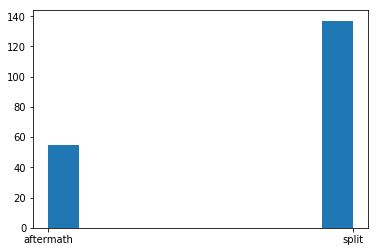

In [35]:
# checking the layouts of the problem cards
layouts=[]
for card in problem_cards:
    layouts.append(cards_df.layout[card])
plt.hist(layouts);

It's pretty clear that all of the problem cards are either split or aftermath cards.  There's not an easy way to look at the data that I've already got and pick out the actual Mana cost though.

I'm just going to scrape the mana costs off of a website.  I've only got about 90 unique cards to look at so I'm going to look them up on Scryfall and hopefully I won't get blocked.

In [36]:
#Getting the names of all of the problem cards
weird_cards=cards_df.loc[(cards_df.layout=='aftermath')|(cards_df.layout=='split')]['name'].unique()
weird_cards

array(['Commit,Memory', 'Cut,Ribbons', 'Destined,Lead', 'Dusk,Dawn',
       'Failure,Comply', 'Heaven,Earth', 'Insult,Injury', 'Mouth,Feed',
       'Never,Return', 'Onward,Victory', 'Prepare,Fight', 'Rags,Riches',
       'Reduce,Rubble', 'Spring,Mind', 'Start,Finish', 'Fire,Ice',
       'Illusion,Reality', 'Life,Death', 'Night,Day', 'Order,Chaos',
       'Wax,Wane', 'Rough,Tumble', 'Trial,Error', 'Farm,Market',
       'Refuse,Cooperate', 'Find,Finality', 'Pain,Suffering', 'Rise,Fall',
       'Spite,Malice', 'Alive,Well', 'Armed,Dangerous', 'Beck,Call',
       'Breaking,Entering', 'Catch,Release', 'Down,Dirty', 'Far,Away',
       'Flesh,Blood', 'Give,Take', 'Profit,Loss', 'Protect,Serve',
       'Ready,Willing', 'Toil,Trouble', 'Turn,Burn', 'Wear,Tear',
       'Bound,Determined', 'Crime,Punishment', 'Hide,Seek', 'Hit,Run',
       'Odds,Ends', 'Pure,Simple', 'Research,Development',
       'Supply,Demand', 'Assure,Assemble', 'Connive,Concoct',
       'Discovery,Dispersal', 'Expansion,Expl

In [37]:
# Getting the urls for the pages with the problem cards
weird_card_urls=pd.read_csv('scryfall_urls.csv')
weird_card_urls.head()

,card,url,Unnamed: 2
0,"Alive,Well",https://scryfall.com/card/dgm/121/alive-well,NaN
1,"Appeal,Authority",https://scryfall.com/card/hou/152/appeal-autho...,NaN
2,"Armed,Dangerous",https://scryfall.com/card/dgm/122/armed-dangerous,NaN
3,"Assault,Battery",https://scryfall.com/card/hop/103/assault-battery,NaN
4,"Assure,Assemble",https://scryfall.com/card/grn/221/assure-assemble,NaN


In [38]:
#cleaning up the URLs dataframe
weird_card_urls.drop('Unnamed: 2',axis=1,inplace=True)
weird_card_urls.head()

,card,url
0,"Alive,Well",https://scryfall.com/card/dgm/121/alive-well
1,"Appeal,Authority",https://scryfall.com/card/hou/152/appeal-autho...
2,"Armed,Dangerous",https://scryfall.com/card/dgm/122/armed-dangerous
3,"Assault,Battery",https://scryfall.com/card/hop/103/assault-battery
4,"Assure,Assemble",https://scryfall.com/card/grn/221/assure-assemble


In [39]:
#grabbing the colors for a card from the Scryfall website
getManaCost(0)

{'card_name': 'Alive,Well',
 'any_color': 3,
 'white': 1,
 'blue': 0,
 'black': 0,
 'red': 0,
 'green': 1,
 'phyrexian': 0,
 'no_color': 0,
 'snow': 0}

In [ ]:
#run this the first time, to get the color data from scryfall.com
weird_card_colors=[]

for card in weird_card_urls.index:
    weird_card_colors.append(getManaCost(card))
    time.sleep(random.randint(1,20))
weird_card_colors_df=pd.DataFrame(weird_card_colors)
weird_card_colors_df.set_index('card_name',inplace=True)
weird_card_colors_df.head()
weird_card_colors_df.to_pickle("split_colors.pkl")

In [40]:
#run this subsequent times to get the color data that's been pickled
weird_card_colors_df = pd.read_pickle("split_colors.pkl")

In [41]:
#The actual color costs for the split/aftermath cards
weird_card_colors_df.head()

,any_color,black,blue,green,no_color,phyrexian,red,snow,white
card_name,,,,,,,,,
"Alive,Well",3,0,0,1,0,0,0,0,1
"Appeal,Authority",1,0,0,1,0,0,0,0,1
"Armed,Dangerous",4,0,0,1,0,0,1,0,0
"Assault,Battery",3,0,0,1,0,0,1,0,0
"Assure,Assemble",4,0,0,3,0,0,0,0,3


In [42]:
#Updating the color columns for the problem cards
colors=['any_color','black','blue','green','no_color','phyrexian','red','snow','white']
for card in colors_df.index:
    card_name=colors_df.card_name[card]
    if card_name in weird_cards:
        for color in colors:
            colors_df[color][card]=weird_card_colors_df[color][card_name]
    else:
        continue      
colors_df.head()

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,any_color,black,blue,card_name,green,no_color,phyrexian,red,snow,white,calculatedManaCost,manaCostComparison
0,2,0,0,Abundance,2,0,0,0,0,0,4,Good
1,2,0,0,Abundance,2,0,0,0,0,0,4,Good
2,1,0,2,Academy Researchers,0,0,0,0,0,0,3,Good
3,1,0,2,Academy Researchers,0,0,0,0,0,0,3,Good
4,0,0,0,Adarkar Wastes,0,0,0,0,0,0,0,Good


In [43]:
#Checking the converted mana cost to make sure it matches with the color columns
color_features=['any_color','black','blue','green','no_color','phyrexian','red','snow','white']
calculated_costs=[]

for card in colors_df.index:
    calculated_mana_cost=0
    for color in color_features:
        calculated_mana_cost+=colors_df[color][card]
    calculated_costs.append(calculated_mana_cost)

colors_df['calculatedManaCost']=calculated_costs
colors_df['manaCostComparison']=['Good' if cards_df.convertedManaCost[x]<=colors_df.calculatedManaCost[x] 
                                 else 'Bad' for x in colors_df.index]
colors_df.head()

,any_color,black,blue,card_name,green,no_color,phyrexian,red,snow,white,calculatedManaCost,manaCostComparison
0,2,0,0,Abundance,2,0,0,0,0,0,4,Good
1,2,0,0,Abundance,2,0,0,0,0,0,4,Good
2,1,0,2,Academy Researchers,0,0,0,0,0,0,3,Good
3,1,0,2,Academy Researchers,0,0,0,0,0,0,3,Good
4,0,0,0,Adarkar Wastes,0,0,0,0,0,0,0,Good


In [44]:
#checking the manaCostComparison for a split card to make sure it's good
colors_df.loc[colors_df.card_name=='Alive,Well']

,any_color,black,blue,card_name,green,no_color,phyrexian,red,snow,white,calculatedManaCost,manaCostComparison
17809,3,0,0,"Alive,Well",1,0,0,0,0,1,5,Good
17810,3,0,0,"Alive,Well",1,0,0,0,0,1,5,Good


All of the cards are good now, so yay! Now I can merge the color columns back into the dataframe and move on with cleaning the data.

In [45]:
#checking to make sure that all of the Mana costs are correct now
colors_df.manaCostComparison.value_counts()

Good    58753
Name: manaCostComparison, dtype: int64

In [46]:
#merging the color columns back into the dataframe
cards_and_colors_df=pd.merge(cards_df,colors_df,left_on=cards_df.index,right_on=colors_df.index)
cards_and_colors_df.head()

,key_0,uuid,name,artist,borderColor,colors,convertedManaCost,flavorText,frameEffects,frameVersion,...,blue,card_name,green,no_color,phyrexian,red,snow,white,calculatedManaCost,manaCostComparison
0,0,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,black,G,4.0,None,None,2003,...,0,Abundance,2,0,0,0,0,0,4,Good
1,1,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,black,G,4.0,None,None,2003,...,0,Abundance,2,0,0,0,0,0,4,Good
2,2,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,black,U,3.0,They brandish their latest theories as warrior...,None,2003,...,2,Academy Researchers,0,0,0,0,0,0,3,Good
3,3,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,black,U,3.0,They brandish their latest theories as warrior...,None,2003,...,2,Academy Researchers,0,0,0,0,0,0,3,Good
4,4,ee19938c-4007-58f1-8904-fae28007b422,Adarkar Wastes,John Avon,black,None,0.0,None,None,2003,...,0,Adarkar Wastes,0,0,0,0,0,0,0,Good


In [47]:
#dropping the mana columns and data columns since I don't need them anymore
cols_to_drop=['key_0','colors','manaCost','priceDate','card_name','calculatedManaCost','manaCostComparison']
cards_and_colors_df.drop(cols_to_drop,axis=1,inplace=True)
cards_and_colors_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58753 entries, 0 to 58752
Data columns (total 50 columns):
uuid                 58753 non-null object
name                 58753 non-null object
artist               58753 non-null object
borderColor          58753 non-null object
convertedManaCost    58753 non-null float64
flavorText           36974 non-null object
frameEffects         1895 non-null object
frameVersion         58753 non-null object
isAlternative        58753 non-null int64
isDateStamped        58753 non-null int64
isFullArt            58753 non-null int64
isPromo              58753 non-null int64
isReserved           58753 non-null int64
isTimeshifted        58753 non-null int64
layout               58753 non-null object
power                28263 non-null object
rarity               58753 non-null object
subtypes             36001 non-null object
supertypes           6004 non-null object
toughness            28263 non-null object
type                 58753 non-null ob

Now I'm going to one-hot encode some of the remaining categorical columns, like `layout` and `borderColor`.

In [48]:
# Looking at how many categories are in each column
features=['artist','borderColor','frameEffects','frameVersion','layout','power','priceType',
          'rarity','subtypes','supertypes','toughness','type','types','setName']
print('Number of categories by feature')
for feature in features:
    print(f'{feature}: {len(cards_and_colors_df[feature].value_counts())}')

Number of categories by feature
artist: 708
borderColor: 4
frameEffects: 22
frameVersion: 5
layout: 9
power: 19
priceType: 2
rarity: 4
subtypes: 1250
supertypes: 6
toughness: 21
type: 1635
types: 17
setName: 271


So, clearly we can't one-hot encode artists, subtypes, or types because any one of those would add an unreasonable amount of columns to the dataframe.  I'll deal with all of those multi-category columns later in a different way.  Anything with 5 or fewer categories is probably safe to one-hot encode though.

In [49]:
#One-hot encoding the appropriate features
cols_to_encode=['borderColor','frameVersion','priceType','rarity']
ohe_df=pd.get_dummies(cards_and_colors_df[cols_to_encode])
ohe_df.head()

,borderColor_black,borderColor_borderless,borderColor_gold,borderColor_white,frameVersion_1993,frameVersion_1997,frameVersion_2003,frameVersion_2015,frameVersion_future,priceType_paper,priceType_paperFoil,rarity_common,rarity_mythic,rarity_rare,rarity_uncommon
0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
4,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [50]:
#Merging the one-hot encoded features back into the dataframe
cards_and_colors_df=pd.merge(cards_and_colors_df,ohe_df,left_on=cards_and_colors_df.index,right_on=ohe_df.index)
cards_and_colors_df.drop(['key_0','borderColor','frameVersion','priceType','rarity'],axis=1,inplace=True)
cards_and_colors_df.head()

,uuid,name,artist,convertedManaCost,flavorText,frameEffects,isAlternative,isDateStamped,isFullArt,isPromo,...,frameVersion_1997,frameVersion_2003,frameVersion_2015,frameVersion_future,priceType_paper,priceType_paperFoil,rarity_common,rarity_mythic,rarity_rare,rarity_uncommon
0,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,4.0,None,None,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,4.0,None,None,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,3.0,They brandish their latest theories as warrior...,None,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,3.0,They brandish their latest theories as warrior...,None,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,ee19938c-4007-58f1-8904-fae28007b422,Adarkar Wastes,John Avon,0.0,None,None,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0


I already used the release date to calculate the card age but I'm also curious to see if the season in which cards are released affects the price of the cards.  I'm going to use the month in the release date to categorize the cards by season.

In [51]:
#binning releaseDate by season
cards_and_colors_df.releaseDate[0].month
cards_and_colors_df['releaseSeason']=['Winter' if cards_and_colors_df.releaseDate[x].month in [12,1,2]
                                     else 'Spring' if cards_and_colors_df.releaseDate[x].month in [3,4,5]
                                     else 'Summer' if cards_and_colors_df.releaseDate[x].month in [6,7,8]
                                     else 'Fall' if cards_and_colors_df.releaseDate[x].month in [9,10,11]
                                     else 'None' for x in cards_and_colors_df.index]
cards_and_colors_df.releaseSeason.value_counts()

Fall      19279
Summer    17197
Spring    12192
Winter    10085
Name: releaseSeason, dtype: int64

In [52]:
# dropping the releaseDate column since I'm done using it now
cards_and_colors_df.drop('releaseDate',axis=1,inplace=True)
cards_and_colors_df.head()

,uuid,name,artist,convertedManaCost,flavorText,frameEffects,isAlternative,isDateStamped,isFullArt,isPromo,...,frameVersion_2003,frameVersion_2015,frameVersion_future,priceType_paper,priceType_paperFoil,rarity_common,rarity_mythic,rarity_rare,rarity_uncommon,releaseSeason
0,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,4.0,None,None,0,0,0,0,...,1,0,0,1,0,0,0,1,0,Summer
1,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,4.0,None,None,0,0,0,0,...,1,0,0,0,1,0,0,1,0,Summer
2,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,3.0,They brandish their latest theories as warrior...,None,0,0,0,0,...,1,0,0,1,0,0,0,0,1,Summer
3,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,3.0,They brandish their latest theories as warrior...,None,0,0,0,0,...,1,0,0,0,1,0,0,0,1,Summer
4,ee19938c-4007-58f1-8904-fae28007b422,Adarkar Wastes,John Avon,0.0,None,None,0,0,0,0,...,1,0,0,1,0,0,0,1,0,Summer


In [53]:
# one-hot encoding the seasons column
seasons=pd.get_dummies(cards_and_colors_df['releaseSeason'])
seasons.head()

,Fall,Spring,Summer,Winter
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [54]:
#merging the seasons columns back into the dataframe
cards_and_all_df=pd.merge(cards_and_colors_df,seasons,left_on=cards_and_colors_df.index,right_on=seasons.index)
cards_and_all_df.head()

,key_0,uuid,name,artist,convertedManaCost,flavorText,frameEffects,isAlternative,isDateStamped,isFullArt,...,priceType_paperFoil,rarity_common,rarity_mythic,rarity_rare,rarity_uncommon,releaseSeason,Fall,Spring,Summer,Winter
0,0,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,4.0,None,None,0,0,0,...,0,0,0,1,0,Summer,0,0,1,0
1,1,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,4.0,None,None,0,0,0,...,1,0,0,1,0,Summer,0,0,1,0
2,2,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,3.0,They brandish their latest theories as warrior...,None,0,0,0,...,0,0,0,0,1,Summer,0,0,1,0
3,3,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,3.0,They brandish their latest theories as warrior...,None,0,0,0,...,1,0,0,0,1,Summer,0,0,1,0
4,4,ee19938c-4007-58f1-8904-fae28007b422,Adarkar Wastes,John Avon,0.0,None,None,0,0,0,...,0,0,0,1,0,Summer,0,0,1,0


In [55]:
#dropping the non-one-hot encoded season column
cards_and_all_df.drop(['key_0','releaseSeason'],axis=1,inplace=True)

I thought about doing text analysis on the flavor text of the cards but I think it's more likely that it's important whether or not a card has flavor text (instead of what exactly the flavor text says).  I'm going to make a column that shows if a card has flavor text or not.

In [56]:
# Making a column that says whether a card has flavorText or not
cards_and_all_df['flavor']=[1 if cards_and_all_df.flavorText[x] else 0 for x in cards_and_all_df.index]
cards_and_all_df[['flavorText','flavor']].head()

,flavorText,flavor
0,None,0
1,None,0
2,They brandish their latest theories as warrior...,1
3,They brandish their latest theories as warrior...,1
4,None,0


In [57]:
#dropping the flavorText column
cards_and_all_df.drop('flavorText',axis=1,inplace=True)
cards_and_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58753 entries, 0 to 58752
Data columns (total 64 columns):
uuid                      58753 non-null object
name                      58753 non-null object
artist                    58753 non-null object
convertedManaCost         58753 non-null float64
frameEffects              1895 non-null object
isAlternative             58753 non-null int64
isDateStamped             58753 non-null int64
isFullArt                 58753 non-null int64
isPromo                   58753 non-null int64
isReserved                58753 non-null int64
isTimeshifted             58753 non-null int64
layout                    58753 non-null object
power                     28263 non-null object
subtypes                  36001 non-null object
supertypes                6004 non-null object
toughness                 28263 non-null object
type                      58753 non-null object
types                     58753 non-null object
setName                   58753 no

In [58]:
#checking out the dataframe to see what else needs done
cards_and_all_df.head()

,uuid,name,artist,convertedManaCost,frameEffects,isAlternative,isDateStamped,isFullArt,isPromo,isReserved,...,priceType_paperFoil,rarity_common,rarity_mythic,rarity_rare,rarity_uncommon,Fall,Spring,Summer,Winter,flavor
0,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,4.0,None,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,4.0,None,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
2,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,3.0,None,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
3,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,3.0,None,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,1
4,ee19938c-4007-58f1-8904-fae28007b422,Adarkar Wastes,John Avon,0.0,None,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


Another things that needs to be straightened out is power and toughness.  Currently, they're strings but they really should be numbers.  Some cards have a variable power and/or toughness though, depending on how much Mana you use to cast it.  Those are denoted with stars (shown by asterisks in this dataframe).  So, I'm going to split the constant part of power/toughness into one column with a second column to show if it's got a star or not.  Then I can change the constant power/toughness columns to floats.

In [59]:
#splitting up the constant and variable parts of power and toughness
cards_and_all_df['starPower']=[1 if cards_and_all_df.power[x] in ['*','1+*','2+*']
                            else 0 for x in cards_and_all_df.index]
cards_and_all_df['starToughness']=[1 if cards_and_all_df.toughness[x] in ['*','1+*','2+*','7-*'] 
                                else 0 for x in cards_and_all_df.index]
cards_and_all_df['power']=[float(cards_and_all_df.power[x]) if cards_and_all_df.power[x] not in [None,'*','1+*','2+*']
                           else 1 if cards_and_all_df.power[x]=='1+*'
                           else 2 if cards_and_all_df.power[x]=='2+*'
                           else 0 for x in cards_and_all_df.index]
cards_and_all_df['toughness']=[float(cards_and_all_df.toughness[x]) if cards_and_all_df.toughness[x] not in [None,'*','1+*','2+*','7-*'] 
                               else 1 if cards_and_all_df.toughness[x]=='1+*'
                               else 2 if cards_and_all_df.toughness[x]=='2+*'
                               else 7 if cards_and_all_df.toughness[x]=='7-*'
                               else 0 for x in cards_and_all_df.index]
cards_and_all_df.head()

,uuid,name,artist,convertedManaCost,frameEffects,isAlternative,isDateStamped,isFullArt,isPromo,isReserved,...,rarity_mythic,rarity_rare,rarity_uncommon,Fall,Spring,Summer,Winter,flavor,starPower,starToughness
0,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,4.0,None,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,1669af17-d287-5094-b005-4b143441442f,Abundance,Rebecca Guay,4.0,None,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,3.0,None,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
3,047d5499-a21c-5f5c-9679-1599fcaf9815,Academy Researchers,Stephen Daniele,3.0,None,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
4,ee19938c-4007-58f1-8904-fae28007b422,Adarkar Wastes,John Avon,0.0,None,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [60]:
#checking out a card that has * power and 1+* toughness to make sure it encoded correctly
cards_and_all_df.loc[cards_and_all_df.name=='Tarmogoyf'][['power','starPower','toughness','starToughness']]

,power,starPower,toughness,starToughness
23721,0.0,1,1.0,1
23722,0.0,1,1.0,1
39006,0.0,1,1.0,1
39007,0.0,1,1.0,1
39496,0.0,1,1.0,1
39497,0.0,1,1.0,1
39951,0.0,1,1.0,1
39952,0.0,1,1.0,1
55743,0.0,1,1.0,1
55744,0.0,1,1.0,1


I've cleaned up the data as much as I can without looking at the price (i.e. the target) column at all.  For everything else, I'll need to involve the price which means I'm going to do a test-train split now and then finish cleaning up the data.

In [61]:
# train test split
X=cards_and_all_df.drop(['price'],axis=1)
y=cards_and_all_df.price
X_train,X_test,y_train,y_test=train_test_split(X,y)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train) #and also getting a validation set

In [62]:
#looking at the lengths of each set
print(f'Training Set length:\t{len(X_train)}')
print(f'Validation Set length:\t{len(X_val)}')
print(f'Test Set length:\t{len(X_test)}')

Training Set length:	33048
Validation Set length:	11016
Test Set length:	14689


I need to figure out a way to group the layouts but I'm unsure how to do that at the moment so I'm going to explore the layout data in a couple different ways to see if anything jumps out at me.

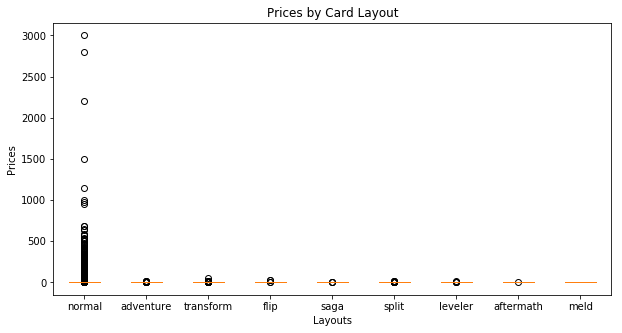

In [63]:
#graphing boxplots of the prices for each layout
layouts=X_train.layout.unique()
prices=[]
for layout in layouts:
    indices=X_train.loc[X_train.layout==layout].index
    prices.append(y_train[indices])
plt.figure(figsize=(10,5))
plt.boxplot(prices,labels=layouts)
plt.xlabel('Layouts')
plt.ylabel('Prices')
plt.title('Prices by Card Layout')
plt.show();

The normal layout cards have a huge range of prices so I'm going to drop that one out and look at the other layouts more closely.

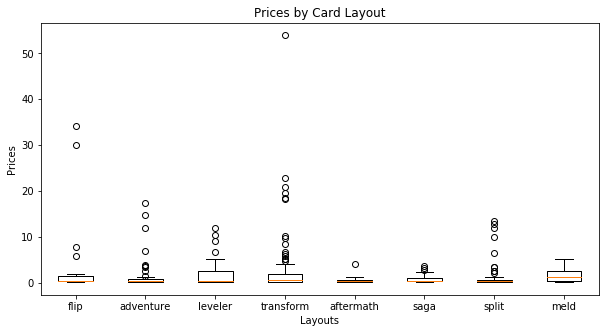

In [64]:
#graphing boxplots for the less common layout types
layouts=['flip','adventure','leveler','transform','aftermath','saga','split','meld']
prices=[]
for layout in layouts:
    indices=X_train.loc[X_train.layout==layout].index
    prices.append(y_train[indices])
plt.figure(figsize=(10,5))
plt.boxplot(prices,labels=layouts)
plt.xlabel('Layouts')
plt.ylabel('Prices')
plt.title('Prices by Card Layout')
plt.show();

Nothing really stands out to me.  Normal layout cards had a much wider range than the other layouts.  All of the median prices look to be about the same, although the meld median might be a little higher.  But there's no clear way to group them yet.

In [65]:
# finding the most common layouts by quartiles of prices
q1=y_train.quantile(0.25)
q2=y_train.quantile(0.5)
q3=y_train.quantile(0.75)
q1_layout_indices=y_train.loc[y_train<q1].index
q2_layout_indices=y_train.loc[(y_train<q2)&(y_train>=q1)].index
q3_layout_indices=y_train.loc[(y_train<q3)&(y_train>=q2)].index
q4_layout_indices=y_train.loc[y_train>=q3].index

In [66]:
#The most common layouts in the first quartile of prices
X_train.layout[q1_layout_indices].value_counts()

normal       7691
adventure      19
transform      17
split          14
leveler        12
aftermath       4
saga            3
flip            1
meld            1
Name: layout, dtype: int64

In [67]:
#The most common layouts in the second quartile of prices
X_train.layout[q2_layout_indices].value_counts()

normal       8412
split          32
transform      26
adventure      12
saga           10
aftermath       9
leveler         9
flip            6
meld            2
Name: layout, dtype: int64

In [68]:
#The most common layouts in the third quartile of prices
X_train.layout[q3_layout_indices].value_counts()

normal       8358
adventure      33
split          31
transform      30
aftermath      23
saga           11
flip           10
leveler         6
Name: layout, dtype: int64

In [69]:
#The most common layouts in the fourth quartile of prices
X_train.layout[q4_layout_indices].value_counts()

normal       8177
transform      37
leveler        15
split          10
adventure       9
flip            7
saga            6
meld            4
aftermath       1
Name: layout, dtype: int64

Nothing really stood out in those either.  Normal is always the most common layout, no matter the quartile.  So, I have another idea.  I'll find the median card price for each of the layouts and then I'll split them into groups based on those prices.  The layouts with the bottom 25% of the prices will go into the first quartile group.  The layouts with median prices in the top 25% will go into the 4th quartile group. And so on.  I'm also going to apply that method to the other columns that I wanted to one-hot encode but that had too many different categories.  (If you'd like to see which layouts, etc are in each quartile group, I'll print them all out in another file called "appendix.")

In [70]:
#joining the prices back into the features dataframe
train_df=X_train.join(y_train)

In [71]:
#finding quartile groups and one-hot encoding them
ohe_features=['artist','frameEffects','layout','supertypes','type','subtypes','setName']
for ohe_feature in ohe_features:
    ohe_feature_df=pd.DataFrame()
    ohe_feature_q1,ohe_feature_q2,ohe_feature_q3,ohe_feature_q4=quantileSort(ohe_feature)
    ohe_feature_df=encoder(ohe_feature,[ohe_feature_q1,ohe_feature_q2,ohe_feature_q3,ohe_feature_q4])
    X_train=X_train.join(ohe_feature_df,rsuffix=str(ohe_feature))
X_train.head()

,uuid,name,artist,convertedManaCost,frameEffects,isAlternative,isDateStamped,isFullArt,isPromo,isReserved,...,Q3_type,Q4_type,Q1_subtypes,Q2_subtypes,Q3_subtypes,Q4_subtypes,Q1_setName,Q2_setName,Q3_setName,Q4_setName
35278,6c802537-c9e3-5e92-9677-ed88788d402e,Creeping Trailblazer,Johan Grenier,2.0,None,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
13582,20dc6211-11c0-59ad-b3f8-68af253918d2,Painwracker Oni,Hideaki Takamura,5.0,None,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
51321,cbaa48e6-1564-5449-9949-9caa90d09761,Promised Kannushi,Matt Thompson,1.0,None,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
42759,8618098f-157b-5246-b0a7-788aba4e29f0,Shadowblood Egg,David Martin,1.0,None,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
32044,4af33c33-dff7-5778-82e4-71c95fd0fd6d,Traumatize,Greg Staples,5.0,None,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [72]:
#looking at missing values for each column
total=len(X_train)
for feature in X_train.columns:
    missing=X_train[feature].isna().sum()
    if missing!=0:
        print(f'{feature} has {missing} missing values. ({round(missing/total*100,2)}%)')

frameEffects has 31992 missing values. (96.8%)
subtypes has 12815 missing values. (38.78%)
supertypes has 29677 missing values. (89.8%)
allText has 582 missing values. (1.76%)


I'm going to drop `frameEffects`, `subtypes`, and `supertypes` because those were all just one-hot encoded so it's fine that they have missing values.  

It also makes sense for about 2% of the cards to not have text.  Some creatures, like Regal Unicorn, just don't have special abilities.  
<center><img src='images/regal-unicorn.jpg' width='300'/></center>
<center><i>Regal Unicorn</i></center>

Next up, I'm going to further analyze the text of the cards to see which command words show up and how they relate to the price of the card.  I'll be using the same method of figuring out which quartile each word falls into but I have to do a little bit more work to get those groups.

In [73]:
#listing out the special phrases that show up in Magic
magic_phrases=['aura swap','bands with other','battle cry','casting cost','converted mana cost','counts as',
               'cumulative upkeep','double strike','end step','enters the battlefield','face down','face up',
               'fateful hour','first strike','global enchanment','hidden agenda','in play','join forces',
               'jump-start','leaves the battlefield','level up','life total','living weapon','local enchantment',
               'lose the game','mono artifact','nonbasic land','outside the game','poly artifact',
               'remove from combat','remove from the game','restart the game','set aside','set in motion',
               'snow-covered','split second','successfully cast','the same is true for','total casting cost',
               'total cost','totem armor','win the game']
magic_phrases_tokenized=[tuple(x.split()) for x in magic_phrases]

In [74]:
#splitting out the card text into its own dataframe so that it's easier to work with
card_text=train_df[['uuid','name','allText','price']].copy()
card_text.head(10)

,uuid,name,allText,price
35278,6c802537-c9e3-5e92-9677-ed88788d402e,Creeping Trailblazer,Other Elementals you control get +1/+0.\n{2}{R...,0.18
13582,20dc6211-11c0-59ad-b3f8-68af253918d2,Painwracker Oni,Fear (This creature can't be blocked except by...,0.25
51321,cbaa48e6-1564-5449-9949-9caa90d09761,Promised Kannushi,"Soulshift 7 (When this creature dies, you may ...",0.10
42759,8618098f-157b-5246-b0a7-788aba4e29f0,Shadowblood Egg,"{2}, {T}, Sacrifice Shadowblood Egg: Add {B}{R...",0.18
32044,4af33c33-dff7-5778-82e4-71c95fd0fd6d,Traumatize,Target player puts the top half of their libra...,1.72
4429,cf397998-7198-5d57-b4dd-e0512483c4df,Reclaim,Put target card from your graveyard on top of ...,0.20
56555,66a34154-2741-541b-ac6e-30b4edbb963e,Eternal Skylord,"When Eternal Skylord enters the battlefield, a...",0.37
26340,ca8215fd-8567-5a34-8adb-612ccae5a276,Green Scarab,Enchant creature\nEnchanted creature can't be ...,0.20
56172,2cd5d2fd-2c3e-51c9-822d-89cd4e880d27,Wildfire,Each player sacrifices four lands. Wildfire de...,0.65
31120,29260540-fe52-5b97-9918-50cd12ccc37a,Changeling Hero,Changeling (This card is every creature type.)...,1.71


In [78]:
#tokenizing the text for one card, to make sure the magic_tokens function works
card=card_text.allText[56555]
magic_tokens(card)

['eternal',
 'skylord',
 'enters_the_battlefield',
 'amass',
 'put',
 'two',
 'counters',
 'army',
 'control',
 'control',
 'one',
 'create',
 'black',
 'zombie',
 'army',
 'creature',
 'token',
 'first',
 'zombie',
 'tokens',
 'control',
 'flying',
 'eternal',
 'skylord',
 'enters_the_battlefield',
 'amass',
 'put',
 'two',
 'counters',
 'army',
 'control',
 'control',
 'one',
 'create',
 'black',
 'zombie',
 'army',
 'creature',
 'token',
 'first',
 'zombie',
 'tokens',
 'control',
 'flying']

In [79]:
#comparing the original text to the tokens in the previous cell
card

"When Eternal Skylord enters the battlefield, amass 2. (Put two +1/+1 counters on an Army you control. If you don't control one, create a 0/0 black Zombie Army creature token first.)\nZombie tokens you control have flying. When Eternal Skylord enters the battlefield, amass 2. <i>(Put two +1/+1 counters on an Army you control. If you don't control one, create a 0/0 black Zombie Army creature token first.)</i>\nZombie tokens you control have flying."

Looks good.  It kept all the important words and dropped the unimportant ones. It also combined "enters the battlefield" into one token (which I wanted it to do, since that's a special Magic phrase that has a particular meaning in the game). It repeated the description (because I combined the two text columns) but that's fine, since I'll just be looking at unique words anyway.  I'm going to tokenize all of the text for each one of the cards in the dataframe.

In [77]:
#tokenizing the text for each card
card_text['token_text']=[magic_tokens(str(card_text.allText[x])) for x in card_text.index]

In [80]:
#dropping the untokenized text column
card_text.drop('allText',axis=1,inplace=True)

Now I'm going to make a list of all of the uinque words on all of the cards so that I can figure out what quartile each word falls into.

In [81]:
#making a list of all of the words on all of the cards in the training set
all_words=[]
for x in card_text.index:
    all_words+=card_text.token_text[x]
all_words=list(set(all_words))
all_words[:10]

['herdcaller',
 'dambreaker',
 'korlash',
 'sledge',
 'seachrome',
 'battlemage',
 'phylactery',
 'urza',
 "pharika's",
 'elenora']

In [82]:
#Figuring out how many words there are total
len(all_words)

8920

The next step turned out to be a bit tricky.  I needed to find the median card price for each word (and there are a lot of words).  I tried doing this a different way at first, the remnants of which can be seen in my library of functions.  But, the fast way to do it was to go through each each card's text and, for each word, add the card's price to a dictionary.  Then, after I ran through all of the cards in the dataframe, I calculated the median price of each card's list in the dictionary.

In [83]:
#finding the median card price for each word
all_word_prices={}
median_prices={}
for card in card_text.index:
    find_word_prices(card)
for word in all_word_prices:
    med=np.median(all_word_prices[word])
    median_prices[word]={'median_price':med,'num_of_cards':len(all_word_prices[word])}

In [84]:
#the median card price for each word as well as the number of cards that each word appears on
word_prices=pd.DataFrame(median_prices).T
word_prices.head()

,median_price,num_of_cards
trailblazer,0.325,6.0
creeping,0.430,3.0
elementals,0.400,16.0
control,0.380,6813.0
get,0.390,1262.0


I realized that some of the more expensive words may only be appearing on one or two cards so let's check it out with a scatter plot.

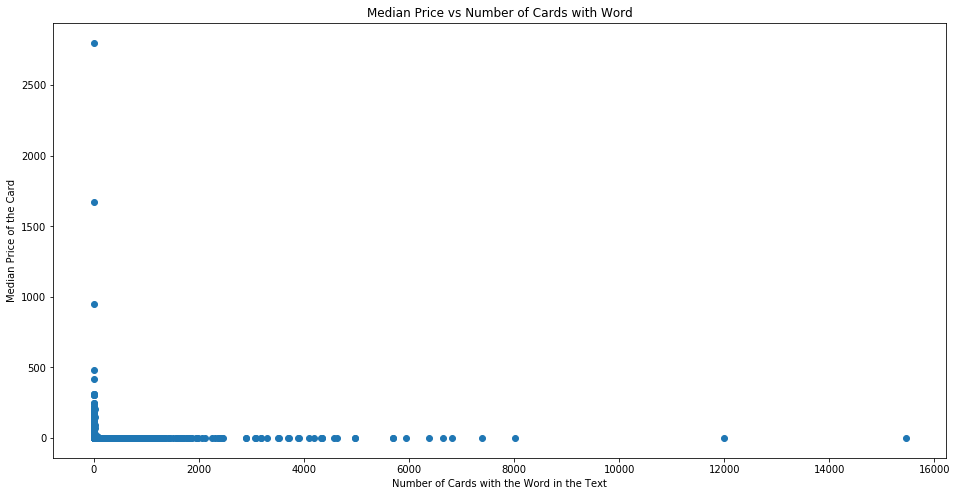

In [85]:
#making a graph to compare the price with the number of cards a word appears on
plt.figure(figsize=(16,8))
plt.scatter(word_prices['num_of_cards'],word_prices['median_price'])
plt.xlabel("Number of Cards with the Word in the Text")
plt.ylabel('Median Price of the Card')
plt.title('Median Price vs Number of Cards with Word');

I think it's safe to say that the more cards that have a word in their text, the lower the median price for that word.  That makes sense, too.  If a word is more common, it probably doesn't do much to increase the value of the card it's on whereas words that are more rarely used might make the card more valuable.  For example, "flying" is a fairly common ability (it shows up on 4000+ cards.  However, "height" is only on a handful of cards (as in, you could literally count the number of cards on your fingers) and it usually means you're going to drop that card from a given height onto the table to determine something. It's a pretty rare ability and, even though it's not on any cards that are playable in competition, it is on some old/expensive ones.

<center><img src='images/chaos-orb.jpg' width=300/></center>
<center><i>When it was legal to use in competition, players would sometimes tear Chaos Orb into little pieces and sprinkle it across the battlefield.</i><center><i><center>While Chaos Orb isn't legal any more, it is still currently worth $300+.</i></center>

In [86]:
#checking out the one-variable statistics for the word prices
word_prices.describe()

,median_price,num_of_cards
count,8920.000000,8920.000000
mean,3.611967,42.792377
std,39.285037,372.730590
min,0.010000,1.000000
25%,0.170000,1.000000
50%,0.320000,2.000000
75%,1.140000,6.000000
max,2799.900000,15454.000000


Next, I need to sort the words into quartiles, based on the numbers from the table above. 

In [87]:
#sorting the words into quartiles
q1=word_prices.median_price.quantile(0.25)
q2=word_prices.median_price.quantile(0.5)
q3=word_prices.median_price.quantile(0.75)

word_prices['quantiles']=['q1' if word_prices.median_price[x]<q1
                        else 'q2' if word_prices.median_price[x]<q2
                        else 'q3' if word_prices.median_price[x]<q3
                        else 'q4' for x in word_prices.index]

In [88]:
#checking out the words dataframe to make sure the quartiles are listed
word_prices.head()

,median_price,num_of_cards,quantiles
trailblazer,0.325,6.0,q3
creeping,0.430,3.0,q3
elementals,0.400,16.0,q3
control,0.380,6813.0,q3
get,0.390,1262.0,q3


The tricky thing now is that each card has a lot of words on it and those words might be from different quartiles.  I'm going to change each unique word in a card's text to its corresponding quartile and then count how many times each quartile shows up.  Then I'll do that for every card in the dataframe.  It's going to take a while.

In [89]:
#making a dictionary of word quartiles to make the next step faster
word_quantiles_dict={x:word_prices.quantiles[x] for x in word_prices.index}

In [91]:
#Testing out the word quartile counting for a card to make sure it works alright
new_text=[word_quantiles_dict[x] for x in list(set(card_text.token_text[35278]))]
q1=new_text.count('q1')
q2=new_text.count('q2')
q3=new_text.count('q3')
q4=new_text.count('q4')
print(q1,q2,q3,q4)

0 3 6 0


In [92]:
#counting the quartiles for all the words on all the cards
q1_words=[]
q2_words=[]
q3_words=[]
q4_words=[]
for card in card_text.index:
    new_text=word_quantiles(card)
    q1_words.append(new_text.count('q1'))
    q2_words.append(new_text.count('q2'))
    q3_words.append(new_text.count('q3'))
    q4_words.append(new_text.count('q4'))
card_text['q1_words']=q1_words
card_text['q2_words']=q2_words
card_text['q3_words']=q3_words
card_text['q4_words']=q4_words

In [93]:
#looking at the card text dataframe to make sure it looks alright
card_text.head()

,uuid,name,price,token_text,q1_words,q2_words,q3_words,q4_words
35278,6c802537-c9e3-5e92-9677-ed88788d402e,Creeping Trailblazer,0.18,"[elementals, control, get, creeping, trailblaz...",0,3,6,0
13582,20dc6211-11c0-59ad-b3f8-68af253918d2,Painwracker Oni,0.25,"[fear, creature, can't, blocked, except, artif...",1,6,6,0
51321,cbaa48e6-1564-5449-9949-9caa90d09761,Promised Kannushi,0.10,"[soulshift, creature, dies, may, return, targe...",1,3,10,0
42759,8618098f-157b-5246-b0a7-788aba4e29f0,Shadowblood Egg,0.18,"[t, sacrifice, shadowblood, egg, add, draw, ca...",0,0,10,1
32044,4af33c33-dff7-5778-82e4-71c95fd0fd6d,Traumatize,1.72,"[target, player, puts, top, half, library, rou...",0,1,6,1


In [94]:
#dropping the unnecessary columns
card_text.drop(['name','price','token_text','uuid'],axis=1,inplace=True)

The dataframe looks good.  The number of words in each quartile have been counted for all of the cards so now I just have to merge that back into the training dataset.

In [95]:
#joining the quartile-ified text dataframe back into the training dataframe
X_train=X_train.join(card_text)
X_train.head()

,uuid,name,artist,convertedManaCost,frameEffects,isAlternative,isDateStamped,isFullArt,isPromo,isReserved,...,Q3_subtypes,Q4_subtypes,Q1_setName,Q2_setName,Q3_setName,Q4_setName,q1_words,q2_words,q3_words,q4_words
35278,6c802537-c9e3-5e92-9677-ed88788d402e,Creeping Trailblazer,Johan Grenier,2.0,None,0,0,0,0,0,...,0,0,1,0,0,0,0,3,6,0
13582,20dc6211-11c0-59ad-b3f8-68af253918d2,Painwracker Oni,Hideaki Takamura,5.0,None,0,0,0,0,0,...,1,0,0,0,1,0,1,6,6,0
51321,cbaa48e6-1564-5449-9949-9caa90d09761,Promised Kannushi,Matt Thompson,1.0,None,0,0,0,0,0,...,1,0,0,0,1,0,1,3,10,0
42759,8618098f-157b-5246-b0a7-788aba4e29f0,Shadowblood Egg,David Martin,1.0,None,0,0,0,0,0,...,0,1,0,0,1,0,0,0,10,1
32044,4af33c33-dff7-5778-82e4-71c95fd0fd6d,Traumatize,Greg Staples,5.0,None,0,0,0,0,0,...,0,1,0,1,0,0,0,1,6,1


### Exploring the Data

I've finally finished cleaning my training set so it's time to move on to some exploration.  The first thing I'm curious about is if there are any highly correlated features in my dataset.  I'm going to check it out with a heatmap.

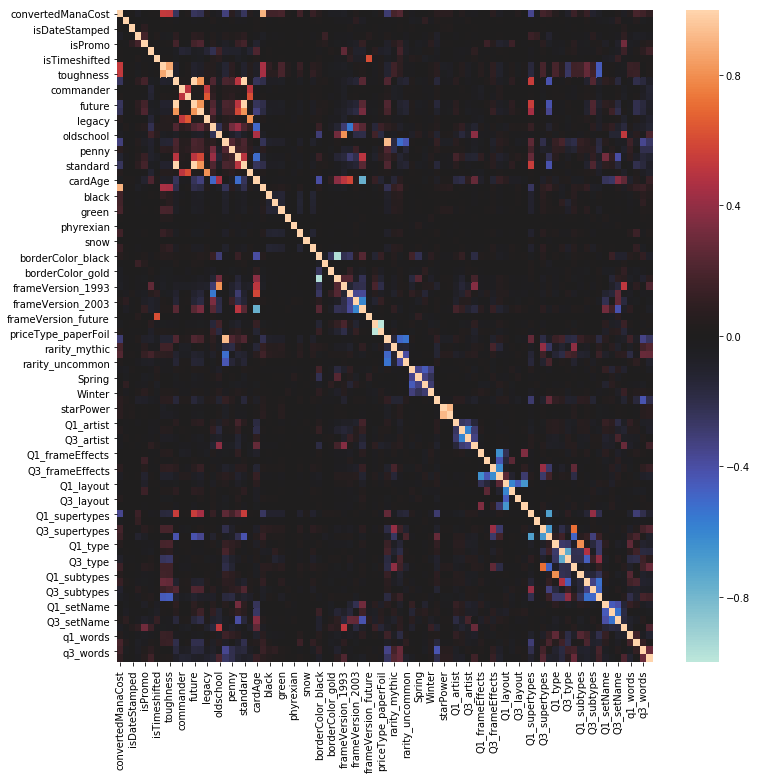

In [96]:
#making a correlation heatmap
plt.figure(figsize=(12,12))
sns.heatmap(X_train.corr(), center=0);

There are a couple of bright spots on the heat map but it's hard to see what they go with so I'm going to list out the features that are highly correlated with more than 1 other feature.

In [97]:
#finding and listing the features that are highly correlated with a lot of other features
corr_matrix=abs(X_train.corr())>0.75
for feature in corr_matrix.index:
    if corr_matrix[feature].sum()>1:
        print(feature,corr_matrix[feature].sum())

convertedManaCost 2
power 2
toughness 2
brawl 4
future 4
historic 4
legacy 2
oldschool 2
pauper 2
standard 4
vintage 2
cardAge 2
any_color 2
borderColor_black 2
borderColor_white 2
frameVersion_1993 2
frameVersion_2015 2
priceType_paper 2
priceType_paperFoil 2
rarity_common 2
starPower 2
starToughness 2
Q1_type 2
Q2_type 2
Q3_type 2
Q1_subtypes 2


I'd like to make a scatter matrix of my features but there are way too many to do all of them so I'll make one with just the features that are highly correlated with more than one feature.

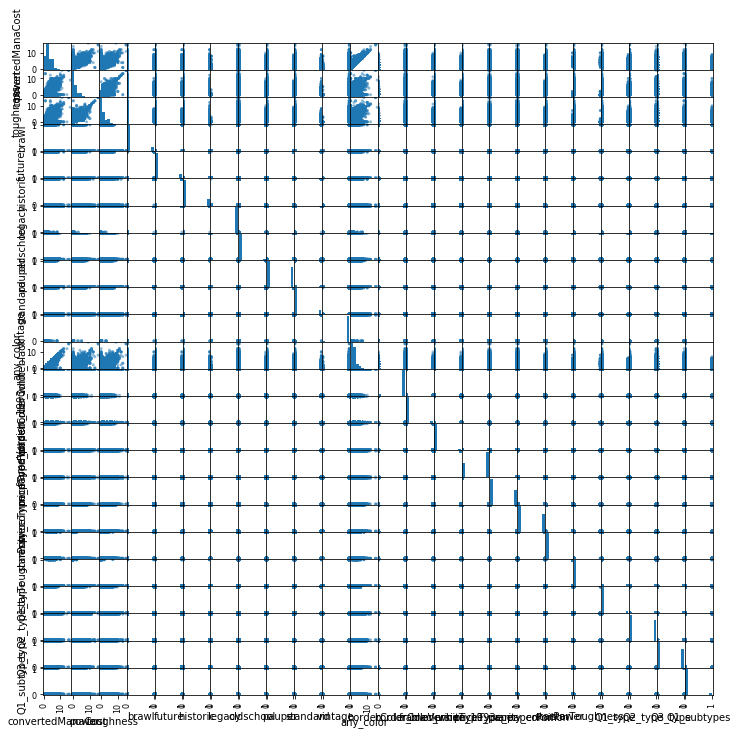

In [98]:
#making a scatter matrix of the features listed above
corr_features=['convertedManaCost','power','toughness','brawl','future','historic','legacy','oldschool','pauper',
               'standard','vintage','any_color','borderColor_black','borderColor_white','frameVersion_1993',
              'priceType_paper','priceType_paperFoil','rarity_common','starPower','starToughness','Q1_type',
              'Q2_type','Q3_type','Q1_subtypes']
pd.plotting.scatter_matrix(X_train[corr_features],figsize=(12,12));

A lot of the features in that scatter matrix are binary so I'm going to just look at the ones that aren't binary.  It's like zooming in on the scatter matrix, in a way.

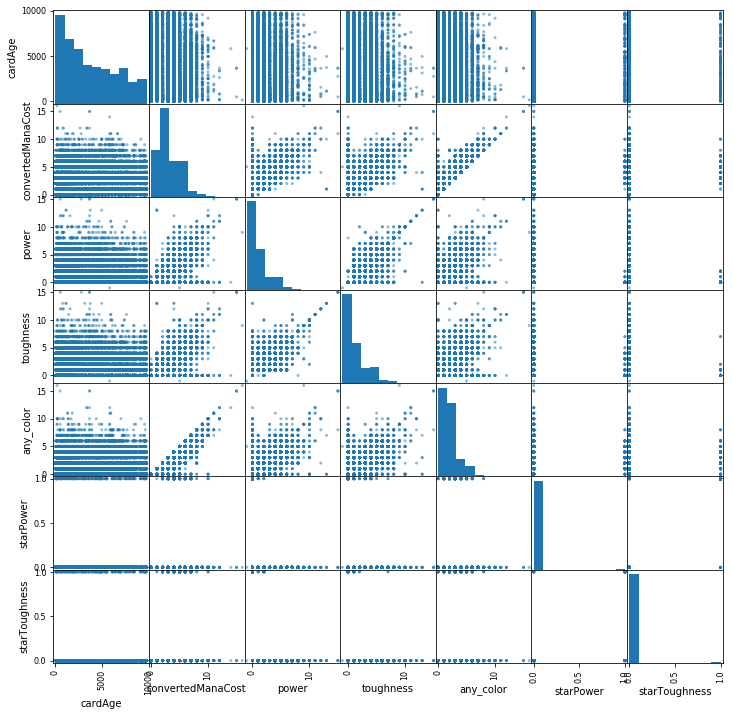

In [99]:
#plotting just the non-binary features
corr_features2=['cardAge','convertedManaCost','power','toughness','any_color','starPower','starToughness']
pd.plotting.scatter_matrix(X_train[corr_features2],figsize=(12,12));

From this matrixt, I notice that converted Mana cost has a nice correlation with any_color as well as power and toughness. Power and toughness also seem to be related to each other - very strongly at numbers above 5 or so and moderately/weakly below that.  Between the scatter matrices and the heatmap though, I don't think any features are highly correlated enough to be thrown out.

I'm curious about card ages. Magic has been around for a really long time and I'm wondering if there's a uniform distribution over the years or if the card production has changed so I'm going to graph the most common card ages.

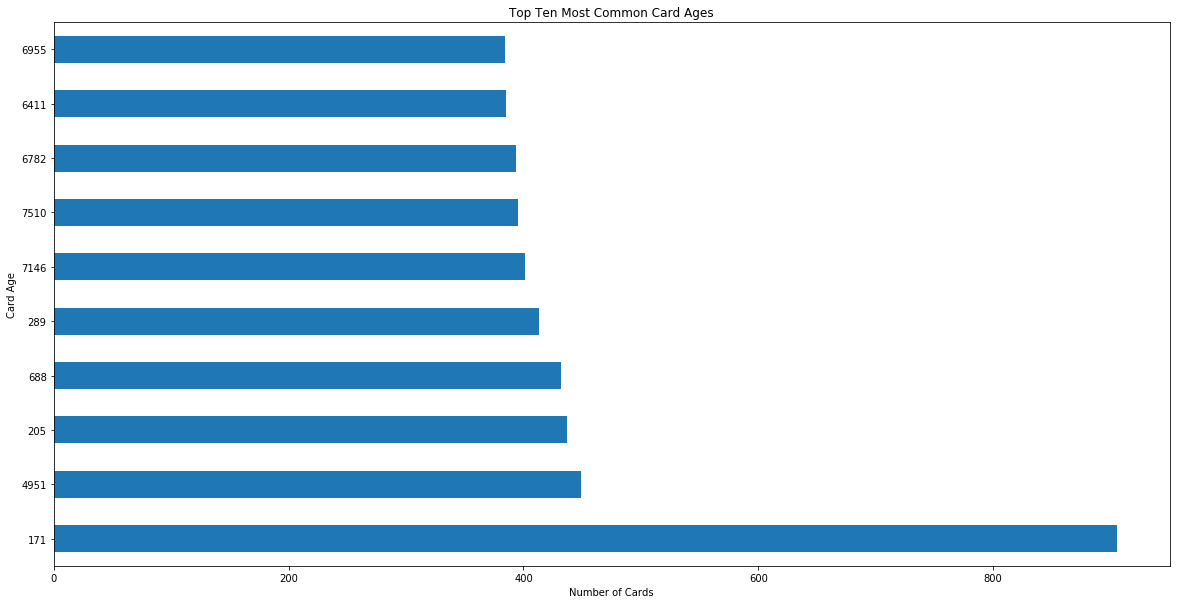

In [100]:
#graphing common card ages
plt.figure(figsize=(20,10))
X_train.cardAge.value_counts()[:10].plot(kind='barh')
plt.xlabel('Number of Cards')
plt.ylabel('Card Age')
plt.title('Top Ten Most Common Card Ages');

It looks strange that there are about twice as many cards in the 1st category as the 2nd category so some further exploration was necessary.  The price dates are all April 24th which means that 171 days before that is sometime in October 2019 which is when the Throne of Eldraine was released.  In that set, Wizards of the Coast introduced Showcase frames so the number of cards in the dataframe is a lot higher than normal (because there's a normal version of a bunch of cards as well as the showcase frame version).  That means that the bar for 171 days being twice as long is not actually weird.

<table>
    <tr><td><img src="images/bonecrusher-giant.jpg" width='300'/></td><td><img src="images/bonecrusher-giant-showcase.jpg" width='300'/></td></tr>
    <tr><td><center><i>Bone Crusher Giant with regular border</i></center></td><td><center><i>Bonecrusher Giant with showcase border</i></center></td></tr></table>

I'm also curious to see how the prices of foil cards compares to nonfoil cards.  I've got the impression that foil cards are more expensive but I'd like to look at the data for them more closely.

In [101]:
#joining the price data back in with my updated training set
train_df=X_train.join(y_train)
train_df.head()

,uuid,name,artist,convertedManaCost,frameEffects,isAlternative,isDateStamped,isFullArt,isPromo,isReserved,...,Q4_subtypes,Q1_setName,Q2_setName,Q3_setName,Q4_setName,q1_words,q2_words,q3_words,q4_words,price
35278,6c802537-c9e3-5e92-9677-ed88788d402e,Creeping Trailblazer,Johan Grenier,2.0,None,0,0,0,0,0,...,0,1,0,0,0,0,3,6,0,0.18
13582,20dc6211-11c0-59ad-b3f8-68af253918d2,Painwracker Oni,Hideaki Takamura,5.0,None,0,0,0,0,0,...,0,0,0,1,0,1,6,6,0,0.25
51321,cbaa48e6-1564-5449-9949-9caa90d09761,Promised Kannushi,Matt Thompson,1.0,None,0,0,0,0,0,...,0,0,0,1,0,1,3,10,0,0.10
42759,8618098f-157b-5246-b0a7-788aba4e29f0,Shadowblood Egg,David Martin,1.0,None,0,0,0,0,0,...,1,0,0,1,0,0,0,10,1,0.18
32044,4af33c33-dff7-5778-82e4-71c95fd0fd6d,Traumatize,Greg Staples,5.0,None,0,0,0,0,0,...,1,0,1,0,0,0,1,6,1,1.72


In [102]:
#getting the card prices for nonfoil cards and for foil cards
paper_card_prices=[]
foil_card_prices=[]
for card in train_df.index:
    if train_df.priceType_paper[card]==1:
        paper_card_prices.append(train_df.price[card])
    else:
        foil_card_prices.append(train_df.price[card])

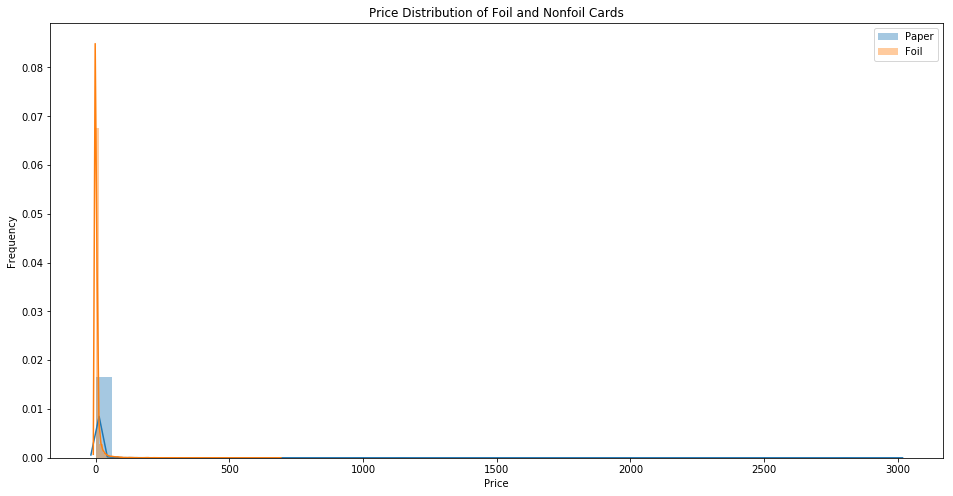

In [104]:
#graphing nonfoil ie paper vs foil price distributions
plt.figure(figsize=(16,8))
sns.distplot(paper_card_prices,label='Paper')
sns.distplot(foil_card_prices,label='Foil')
plt.legend()
plt.title('Price Distribution of Foil and Nonfoil Cards')
plt.xlabel('Price')
plt.ylabel('Frequency');

That graph is difficult to read and it looks like there are a lot of outliers, especially for nonfoil (i.e. paper) cards.  So, I'm going to get rid of the outliers for both types of cards and then graph the distributions again.

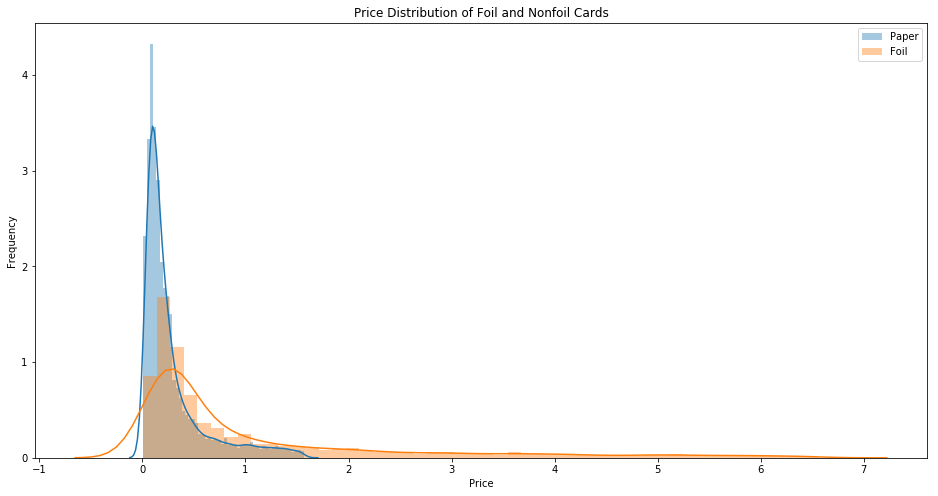

In [105]:
q1_paper=np.quantile(paper_card_prices,0.25)
q3_paper=np.quantile(paper_card_prices,0.75)
iqr_paper=q3_paper-q1_paper
upper_limit_paper=1.5*iqr_paper+q3_paper
no_paper_outliers=[x for x in paper_card_prices if x<upper_limit_paper]

q1_foil=np.quantile(foil_card_prices,0.25)
q3_foil=np.quantile(foil_card_prices,0.75)
iqr_foil=q3_foil-q1_foil
upper_limit_foil=1.5*iqr_foil+q3_foil
no_foil_outliers=[x for x in foil_card_prices if x<upper_limit_foil]

plt.figure(figsize=(16,8))
sns.distplot(no_paper_outliers,label='Paper')
sns.distplot(no_foil_outliers,label='Foil')
plt.legend()
plt.title('Price Distribution of Foil and Nonfoil Cards')
plt.xlabel('Price')
plt.ylabel('Frequency');

The median price is definitely higher for foil cards but it also seems to have a higher standard deviation (i.e. more variation).  Paper (nonfoil) cards have a lower median and less variation (but it's important to remember that this is after the outliers have been removed).  I would guess that this may end up being an important feature for my model.

I'm also interested in comparing the card age with the frame version.  It seems like those should be highly correlated, since the frame versions are named by the year in which they came out (with the exception of the future frame version - that's a whole other thing all by itself).

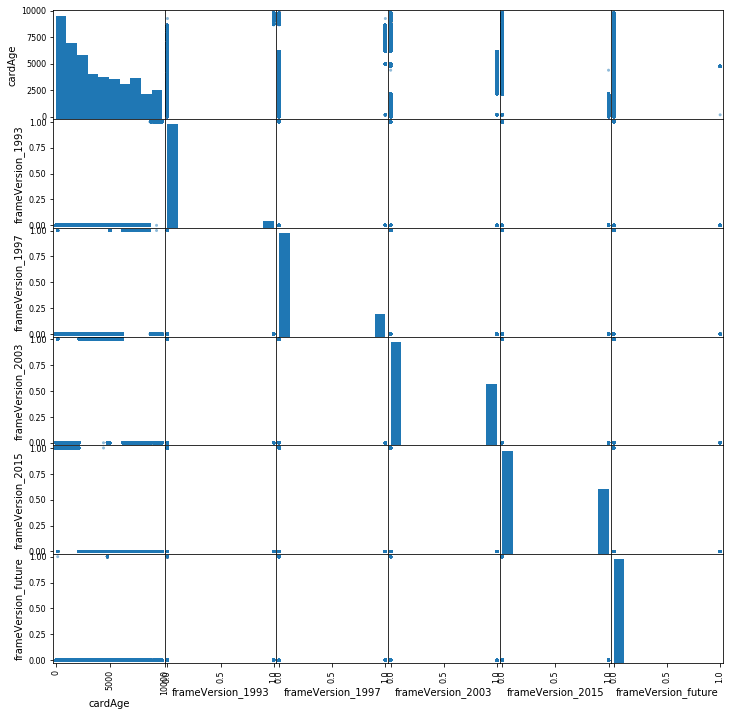

In [106]:
#making a scatter matrixt to compare card age and frame versionb
age_columns=['cardAge','frameVersion_1993','frameVersion_1997', 'frameVersion_2003', 'frameVersion_2015','frameVersion_future']
pd.plotting.scatter_matrix(X_train[age_columns],figsize=(12,12));

Honestly, I don't see much of anything in that scatter matrix.  It looks like there could be a relationship but it's not super strong.  I'm going to try looking at the same features but with a heatmap.

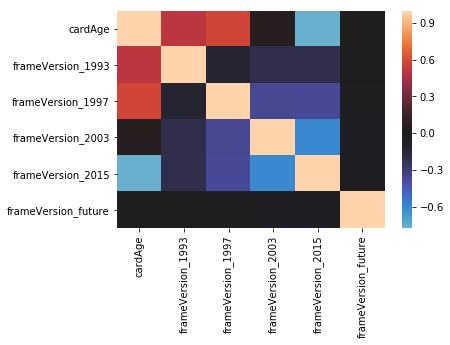

In [107]:
#making a heat map of card age and frame version
sns.heatmap(X_train[age_columns].corr(), center=0);

Nothing looks highly correlated there either.  Oh well.

Next, I'd like to see how the words stack up.  I'm going to graph the word quartiles by how many times they show up on a card.

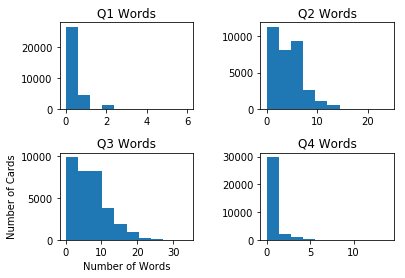

In [108]:
#graphing word quartile histograms
f, axarr = plt.subplots(2, 2)
axarr[0, 0].hist(q1_words)
axarr[0, 0].set_title('Q1 Words')
axarr[0, 1].hist(q2_words)
axarr[0, 1].set_title('Q2 Words')
axarr[1, 0].hist(q3_words)
axarr[1, 0].set_title('Q3 Words')
axarr[1, 0].set_xlabel('Number of Words')
axarr[1, 0].set_ylabel('Number of Cards')
axarr[1, 1].hist(q4_words)
axarr[1, 1].set_title('Q4 Words')
plt.subplots_adjust(hspace=0.5,wspace=0.5);

It looks like the Q1 and Q4 words show up least often on cards. (I mean, if a card has a Q1 or Q4 word, it might only have a couple of them whereas Q2 or Q3 words might appear several times on one card).   Cards tend to have higher numbers of Q2 or Q3 words on them.  I'm guessing that either Q1/Q4 words or Q2/Q3 words may be important features in my model.

Next, I'm going to check out the which features need to be standardized.  I'm going to graph histograms for each feature and look at the x-axes to make sure they fall in the single digit range.  If they don't, I'll use a standard scaler to scale them.

In [109]:
#listing out the actual features for my model to be trained on
actual_features=['convertedManaCost','isAlternative','isDateStamped','isFullArt','isPromo','isReserved','isTimeshifted',
         'power','toughness','brawl','commander','duel','future','historic','legacy','modern','oldschool','pauper',
         'penny','pioneer','standard','vintage','cardAge','any_color','black','blue','green','no_color','phyrexian',
         'red','snow','white','borderColor_borderless','borderColor_gold','borderColor_white','frameVersion_1997',
         'frameVersion_2003','frameVersion_2015','frameVersion_future','priceType_paperFoil','rarity_mythic', 
         'rarity_rare','rarity_uncommon','Spring','Summer','Winter','flavor','starPower','starToughness','Q2_artist',
         'Q3_artist','Q4_artist','Q2_frameEffects','Q3_frameEffects','Q4_frameEffects','Q2_layout','Q3_layout',
         'Q4_layout','Q2_supertypes','Q3_supertypes','Q4_supertypes','Q2_setName','Q3_setName','Q4_setName','q1_words',
         'q2_words','q3_words','q4_words']
cols_to_drop=['types','allText','borderColor_black','frameVersion_1993','priceType_paper','rarity_common','Fall',
             'Q1_artist','Q1_frameEffects','Q1_layout','Q1_supertypes','Q1_setName']

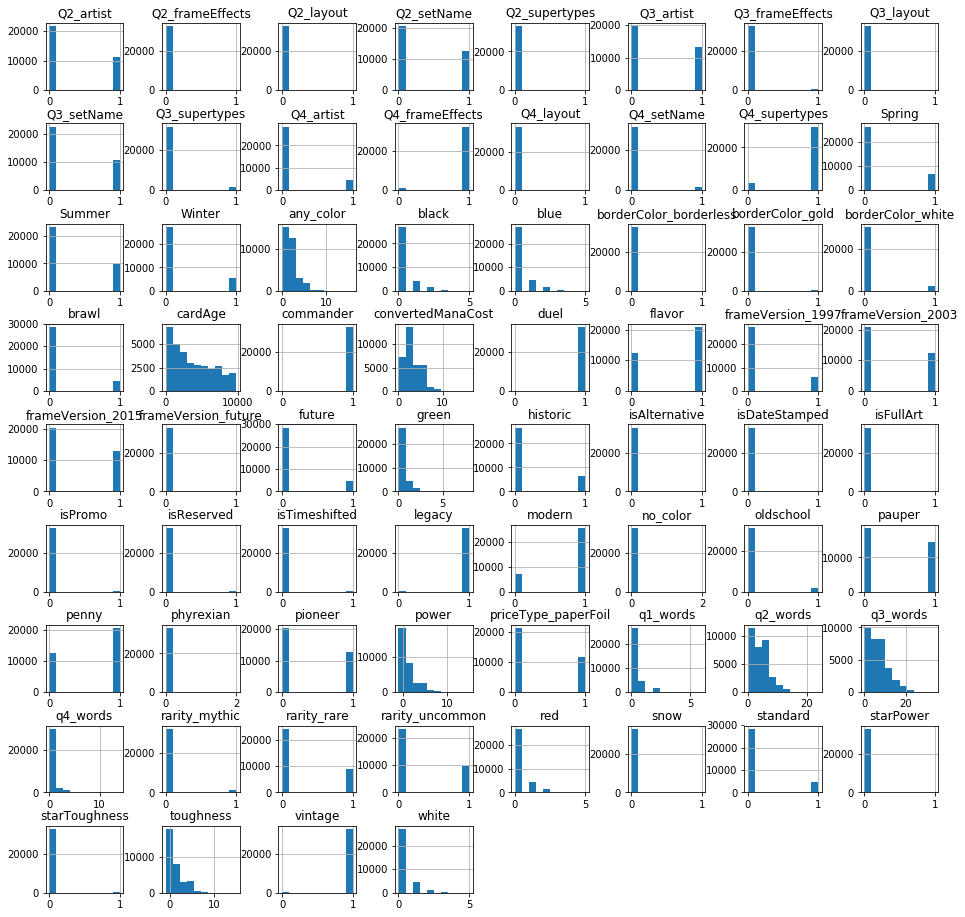

In [110]:
#making histograms of the actual features, to see what needs standardized
X_train[actual_features].hist(figsize=(16,16))
plt.subplots_adjust(hspace=0.5,wspace=0.5);

There are only a few features that have big x-values so I'll list those out and then standardize them.

In [111]:
#listing the features that need standardized
features_to_standardize=['any_color','cardAge','convertedManaCost','power','q2_words','q3_words','q4_words','toughness']

In [112]:
#creating a scaler and standardizing the appropraite features
scaler=StandardScaler()
X_train[features_to_standardize]=scaler.fit_transform(X_train[features_to_standardize])

In [113]:
#checking out the dataframe to make sure they were actually standardized
X_train.head()

,uuid,name,artist,convertedManaCost,frameEffects,isAlternative,isDateStamped,isFullArt,isPromo,isReserved,...,Q3_subtypes,Q4_subtypes,Q1_setName,Q2_setName,Q3_setName,Q4_setName,q1_words,q2_words,q3_words,q4_words
35278,6c802537-c9e3-5e92-9677-ed88788d402e,Creeping Trailblazer,Johan Grenier,-0.531442,None,0,0,0,0,0,...,0,0,1,0,0,0,0,-0.375378,-0.154549,-0.442131
13582,20dc6211-11c0-59ad-b3f8-68af253918d2,Painwracker Oni,Hideaki Takamura,1.049015,None,0,0,0,0,0,...,1,0,0,0,1,0,1,0.612871,-0.154549,-0.442131
51321,cbaa48e6-1564-5449-9949-9caa90d09761,Promised Kannushi,Matt Thompson,-1.058261,None,0,0,0,0,0,...,1,0,0,0,1,0,1,-0.375378,0.675470,-0.442131
42759,8618098f-157b-5246-b0a7-788aba4e29f0,Shadowblood Egg,David Martin,-1.058261,None,0,0,0,0,0,...,0,1,0,0,1,0,0,-1.363626,0.675470,0.637088
32044,4af33c33-dff7-5778-82e4-71c95fd0fd6d,Traumatize,Greg Staples,1.049015,None,0,0,0,0,0,...,0,1,0,1,0,0,0,-1.034210,-0.154549,0.637088


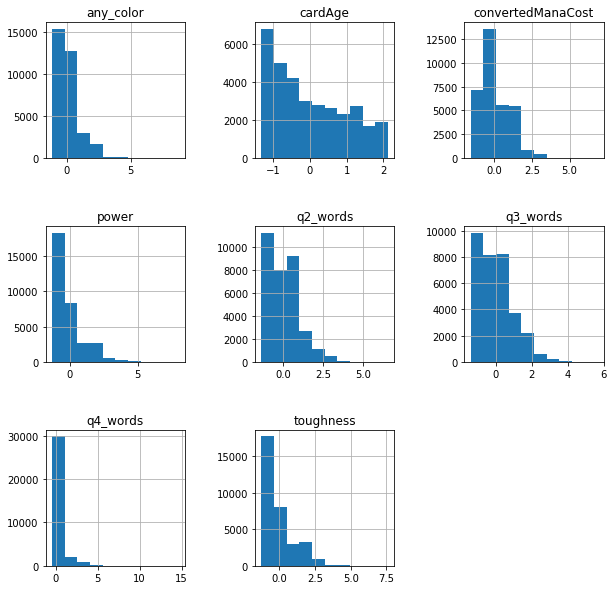

In [114]:
#looking at the standardized histograms
X_train[features_to_standardize].hist(figsize=(10,10))
plt.subplots_adjust(hspace=0.5,wspace=0.5);

Now that my training set is all ready to go, I'm going to prep my validation and testing sets following the same steps.

In [115]:
#required values from training dataset

#quartile groups
q1_artist,q2_artist,q3_artist,q4_artist=quantileSort('artist')
artist_groups=[q1_artist,q2_artist,q3_artist,q4_artist]

q1_frameEffects,q2_frameEffects,q3_frameEffects,q4_frameEffects=quantileSort('frameEffects')
frame_effect_groups=[q1_frameEffects,q2_frameEffects,q3_frameEffects,q4_frameEffects]

q1_layout,q2_layout,q3_layout,q4_layout=quantileSort('layout')
layout_groups=[q1_layout,q2_layout,q3_layout,q4_layout]

q1_supertypes,q2_supertypes,q3_supertypes,q4_supertypes=quantileSort('supertypes')
supertype_groups=[q1_supertypes,q2_supertypes,q3_supertypes,q4_supertypes]

q1_type,q2_type,q3_type,q4_type=quantileSort('type')
type_groups=[q1_type,q2_type,q3_type,q4_type]

q1_subtypes,q2_subtypes,q3_subtypes,q4_subtypes=quantileSort('subtypes')
subtype_groups=[q1_subtypes,q2_subtypes,q3_subtypes,q4_subtypes]

q1_setName,q2_setName,q3_setName,q4_setName=quantileSort('setName')
setName_groups=[q1_setName,q2_setName,q3_setName,q4_setName]

In [116]:
#One hot encoded features by quartile
ohe_features=['artist','frameEffects','layout','supertypes','type','subtypes','setName']
ohe_groups=[artist_groups,frame_effect_groups,layout_groups,supertype_groups,type_groups,subtype_groups,setName_groups]

In [117]:
##One hot encoding features by quartile, tokenizing text, and standardizing features
X_test=preprocess_ohe(ohe_features,ohe_groups,X_test)
X_test=preprocess_tokenize(X_test)
X_test[features_to_standardize]=scaler.transform(X_test[features_to_standardize])

X_val=preprocess_ohe(ohe_features,ohe_groups,X_val)
X_val=preprocess_tokenize(X_val)
X_val[features_to_standardize]=scaler.transform(X_val[features_to_standardize])

In [118]:
#listing the features and columns to drop
features=['convertedManaCost','isAlternative','isDateStamped','isFullArt','isPromo','isReserved',
          'isTimeshifted','power','toughness','brawl','commander','duel','future', 'historic',
          'legacy','modern','oldschool','pauper','penny','pioneer','standard','vintage','cardAge',
          'any_color', 'black', 'blue', 'green', 'no_color', 'phyrexian', 'red','snow', 'white',
          'borderColor_borderless','borderColor_gold','borderColor_white','frameVersion_1997',
          'frameVersion_2003','frameVersion_2015','frameVersion_future','priceType_paperFoil',
          'rarity_mythic','rarity_rare','rarity_uncommon','Spring','Summer','Winter','flavor',
          'starPower','starToughness','Q2_artist','Q3_artist','Q4_artist','Q2_frameEffects',
          'Q3_frameEffects','Q4_frameEffects','Q2_layout','Q3_layout','Q4_layout','Q2_supertypes',
          'Q3_supertypes','Q4_supertypes','Q2_type','Q3_type','Q4_type','Q2_subtypes',
          'Q3_subtypes','Q4_subtypes','Q2_setName','Q3_setName','Q4_setName','q1_words','q2_words',
          'q3_words','q4_words']
cols_to_drop=['artist','frameEffects','layout','subtypes','supertypes','type','types', 'setName',
              'allText','borderColor_black','frameVersion_1993','priceType_paper','rarity_common',
              'Fall','Q1_artist','Q1_frameEffects','Q1_layout','Q1_supertypes','Q1_type','Q1_subtypes',
              'Q1_setName']

In [119]:
#dropping the appropriate columns
X_train.drop(cols_to_drop,axis=1,inplace=True)
X_test.drop(cols_to_drop,axis=1,inplace=True)
X_val.drop(cols_to_drop,axis=1,inplace=True)

Ok, my training, validation, and testing datasets are all ready to go.  Time to build a model!

### Modeling

Since I'm predicting a continuous variable, I'll need to use a regression model.  I already know that this is too complex for a linear so I'm just going to jump straight to using and XGBoost model.  I'll start with a vanilla one, so I have something to compare later versions of the model to.

In [120]:
#Instantiating Vanilla Regression Model
xgb_reg=xgb.XGBRegressor()

In [121]:
#fitting vanilla model and comparing performance for training and validation sets
X_train_set=X_train[features]
X_val_set=X_val[features]
eval_set=[(X_val_set,y_val)]
xgb_reg.fit(X_train_set,y_train,eval_set=eval_set,verbose=False)
y_train_pred=xgb_reg.predict(X_train_set)
y_val_pred=xgb_reg.predict(X_val_set)
print(f'XGBoost Statistics\n')
print("Mean Absolute Error (Training Set): " + str(mean_absolute_error(y_train_pred, y_train)))
print("Mean Absolute Error (Validation Set): " + str(mean_absolute_error(y_val_pred, y_val)))
print("Root Mean Squared Error (Training Set): " + str(np.sqrt(mean_squared_error(y_train_pred, y_train))))
print("Root Mean Squared Error (Validation Set): " + str(np.sqrt(mean_squared_error(y_val_pred, y_val))))

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:28:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Statistics

Mean Absolute Error (Training Set): 3.800658506678701
Mean Absolute Error (Validation Set): 4.186245487232679
Root Mean Squared Error (Training Set): 18.46111424351282
Root Mean Squared Error (Validation Set): 28.869445007464297


In [122]:
#Checking the model performance
exp_var_train=explained_variance_score(y_train_pred,y_train)
exp_var_val=explained_variance_score(y_val_pred,y_val)
print('Explained Variance Scores')
print(f'Training: {exp_var_train}')
print(f'Validation: {exp_var_val}')

Explained Variance Scores
Training: 0.49766709865814374
Validation: -0.3034842490637364


The vanilla model isn't that great with explained variance.  The errors are pretty low but the training and validation RMSEs are different so the model is likely overfitting a little.

I'm going to try a number of things to improve on the model.  First up, I'm going to look at early stopping and the number of estimators.  I'm going to pick a number of rounds for stopping early and I'll vary the number of estimators to see if I can determine an optimal number.

In [123]:
#Using early_stopping to figure out the best number of estimators
train_MAE=[]
val_MAE=[]
train_RMSE=[]
val_RMSE=[]
estimators=list(range(1,1051,25))
for n in estimators:
    early_stopping_xgb=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=n)
    early_stopping_xgb.fit(X_train_set,y_train,early_stopping_rounds=5,eval_set=eval_set,verbose=False)
    y_train_pred=early_stopping_xgb.predict(X_train_set)
    y_val_pred=early_stopping_xgb.predict(X_val_set)
    train_MAE.append(mean_absolute_error(y_train_pred, y_train))
    val_MAE.append(mean_absolute_error(y_val_pred, y_val))
    train_RMSE.append(np.sqrt(mean_squared_error(y_train_pred, y_train)))
    val_RMSE.append(np.sqrt(mean_squared_error(y_val_pred, y_val)))

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is de

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


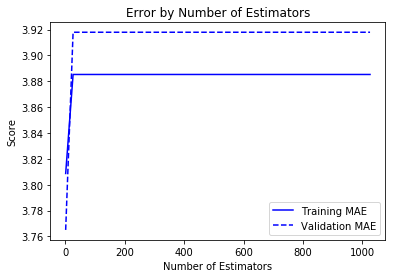

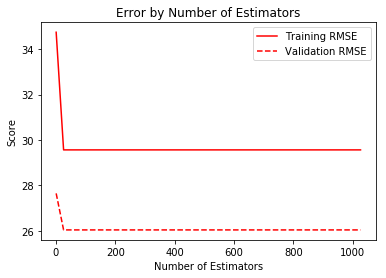

In [124]:
#graphs
plt.plot(estimators,train_MAE,label='Training MAE',linestyle='-',color='blue')
plt.plot(estimators,val_MAE,label='Validation MAE',linestyle='--',color='blue')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Error by Number of Estimators')
plt.legend()
plt.show();
plt.plot(estimators,train_RMSE,label='Training RMSE',linestyle='-',color='red')
plt.plot(estimators,val_RMSE,label='Validation RMSE',linestyle='--',color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Error by Number of Estimators')
plt.legend();

The best number of estimators looks really low.  I don't really want to limit it to the 25-ish that the graphs are suggesting without doing a lot of further investigation.  

So, let's switch it around.  I'm going to pick a number of estimators and then vary the number of rounds for early stopping.

In [125]:
#Figuring out best number of early stopping rounds
train_MAE=[]
val_MAE=[]
train_RMSE=[]
val_RMSE=[]
rounds=range(1,111,10)
for r in rounds:
    early_stopping_xgb=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000)
    early_stopping_xgb.fit(X_train_set,y_train,early_stopping_rounds=r,eval_set=eval_set,verbose=False)
    y_train_pred=early_stopping_xgb.predict(X_train_set)
    y_val_pred=early_stopping_xgb.predict(X_val_set)
    train_MAE.append(mean_absolute_error(y_train_pred, y_train))
    val_MAE.append(mean_absolute_error(y_val_pred, y_val))
    train_RMSE.append(np.sqrt(mean_squared_error(y_train_pred, y_train)))
    val_RMSE.append(np.sqrt(mean_squared_error(y_val_pred, y_val)))

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is de

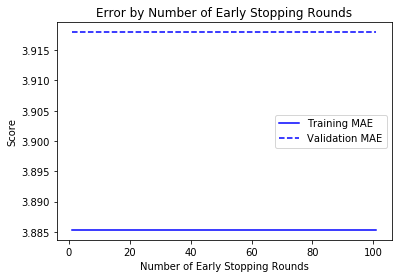

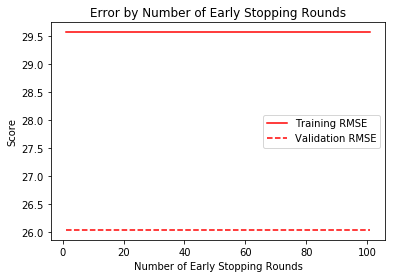

In [126]:
#graphs
plt.plot(rounds,train_MAE,label='Training MAE',linestyle='-',color='blue')
plt.plot(rounds,val_MAE,label='Validation MAE',linestyle='--',color='blue')
plt.xlabel('Number of Early Stopping Rounds')
plt.ylabel('Score')
plt.title('Error by Number of Early Stopping Rounds')
plt.legend()
plt.show();
plt.plot(rounds,train_RMSE,label='Training RMSE',linestyle='-',color='red')
plt.plot(rounds,val_RMSE,label='Validation RMSE',linestyle='--',color='red')
plt.xlabel('Number of Early Stopping Rounds')
plt.ylabel('Score')
plt.title('Error by Number of Early Stopping Rounds')
plt.legend();

Looks like the number of early stopping rounds might not make that much of a difference in this case so I'll stick with 5.

Next, I'm going to do a gridsearch to figure out some good parameters.  I don't have a lot of processing power in this computer so it's not going to be a huge grid.  I'll vary the tree method, subsample size, and gamma value.

In [127]:
#using a gridsearch to figure out best hyperparameters
xgb_searching=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000,early_stopping_rounds=5)
xgb_param_grid={'tree_method':['approx','hist'],
                'subsample':[0.5,1],
                'gamma':[0,5,10]}
grid_search=GridSearchCV(xgb_searching,xgb_param_grid,cv=3,return_train_score=True)
grid_search.fit(X_train_set,y_train)
training_score = np.mean(grid_search.cv_results_['mean_train_score'])
val_score = grid_search.score(X_val_set,y_val)
print(f"Mean Training Score: {training_score :.2%}")
print(f"Mean Validation Score: {val_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is de

Mean Training Score: 89.74%
Mean Validation Score: 1.59%
Best Parameter Combination Found During Grid Search:


In [128]:
#listing the best parameters found in the grid search
print(grid_search.best_params_)

{'gamma': 0, 'subsample': 0.5, 'tree_method': 'hist'}


Now that I've got those parameters, I'm going to run the model again (with those parameters) and then evaluate it.

In [129]:
#running the model again but with the best parameters from the grid search
xgb_best=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000,
                                        early_stopping_rounds=5,gamma=0,subsample=0.5,tree_method='hist')
xgb_best.fit(X_train_set,y_train,eval_set=eval_set,verbose=False)
y_train_pred=xgb_best.predict(X_train_set)
y_val_pred=xgb_best.predict(X_val_set)
print(f'XGBoost Statistics\n')
print("Mean Absolute Error (Training Set): " + str(mean_absolute_error(y_train_pred, y_train)))
print("Mean Absolute Error (Validation Set): " + str(mean_absolute_error(y_val_pred, y_val)))
print("Root Mean Squared Error (Training Set): " + str(np.sqrt(mean_squared_error(y_train_pred, y_train))))
print("Root Mean Squared Error (Validation Set): " + str(np.sqrt(mean_squared_error(y_val_pred, y_val))))

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBoost Statistics

Mean Absolute Error (Training Set): 3.3378419390022107
Mean Absolute Error (Validation Set): 4.268789914949225
Root Mean Squared Error (Training Set): 11.988353485769522
Root Mean Squared Error (Validation Set): 27.873717947930576


Next, I want to see how my model performs on the testing data.

In [130]:
#evaluating the model with the testing dataset
X_test_set=X_test[features]
y_test_pred=xgb_best.predict(X_test_set)
print("Mean Absolute Error (Test Set): " + str(mean_absolute_error(y_test_pred, y_test)))
print("Root Mean Squared Error (Test Set): " + str(np.sqrt(mean_squared_error(y_test_pred, y_test))))

Mean Absolute Error (Test Set): 4.869279161327765
Root Mean Squared Error (Test Set): 45.04049187935184


Finally, I want to check out the explained variance scores to see how my model did.  The higher the score, the better. 

In [131]:
#Evaluating with the explained variance scores
exp_var_train=explained_variance_score(y_train_pred,y_train)
exp_var_val=explained_variance_score(y_val_pred,y_val)
exp_var_test=explained_variance_score(y_test_pred,y_test)
print('Explained Variance Scores')
print(f'Training: {exp_var_train}')
print(f'Validation: {exp_var_val}')
print(f'Testing: {exp_var_test}')

Explained Variance Scores
Training: 0.8671148267787713
Validation: -0.159214322651537
Testing: -0.3239435831601776


It did pretty well for the Training set but the other two are questionable.  Now, I want to try one more thing: standardizing the output sets.  I'm going to do that and then rerun the model to see what happens.  Hopefully it'll improve the performance more.

In [132]:
#scaling the outcome data
y_train_mean=np.mean(y_train)
y_train_std=np.std(y_train)
y_train_scaled=[(x-y_train_mean)/y_train_std for x in y_train]
y_val_scaled=[(x-y_train_mean)/y_train_std for x in y_val]
y_test_scaled=[(x-y_train_mean)/y_train_std for x in y_test]

In [133]:
#Vanilla XGBRegressor
xgb_scaled=xgb.XGBRegressor()
eval_set_scaled=[(X_val_set,y_val_scaled)]
xgb_scaled.fit(X_train_set,y_train_scaled,eval_set=eval_set_scaled,verbose=False)
y_train_pred=xgb_reg.predict(X_train_set)
y_val_pred=xgb_reg.predict(X_val_set)
print(f'XGBoost Statistics\n')
print("Mean Absolute Error (Training Set): " + str(mean_absolute_error(y_train_pred, y_train_scaled)))
print("Mean Absolute Error (Validation Set): " + str(mean_absolute_error(y_val_pred, y_val_scaled)))
print("Root Mean Squared Error (Training Set): " + str(np.sqrt(mean_squared_error(y_train_pred, y_train_scaled))))
print("Root Mean Squared Error (Validation Set): " + str(np.sqrt(mean_squared_error(y_val_pred, y_val_scaled))))

[13:50:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Statistics

Mean Absolute Error (Training Set): 4.374923745247722
Mean Absolute Error (Validation Set): 4.279679964574476
Root Mean Squared Error (Training Set): 25.499613138033602
Root Mean Squared Error (Validation Set): 25.265145821927646


The MAE and RMSE are higher than without the scaled outcome data but the training and validation scores are way closer to each other so that indicates that this is a more robust model. It also means I should rerun my other model but with the scaled outcome data.

In [134]:
#varying the estimators with a constant early_stopping
train_MAE=[]
val_MAE=[]
train_RMSE=[]
val_RMSE=[]
estimators=list(range(1,1051,25))
for n in estimators:
    early_stopping_xgb_scaled=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=n)
    early_stopping_xgb_scaled.fit(X_train_set,y_train_scaled,early_stopping_rounds=5,eval_set=eval_set_scaled,verbose=False)
    y_train_pred=early_stopping_xgb_scaled.predict(X_train_set)
    y_val_pred=early_stopping_xgb_scaled.predict(X_val_set)
    train_MAE.append(mean_absolute_error(y_train_pred, y_train_scaled))
    val_MAE.append(mean_absolute_error(y_val_pred, y_val_scaled))
    train_RMSE.append(np.sqrt(mean_squared_error(y_train_pred, y_train_scaled)))
    val_RMSE.append(np.sqrt(mean_squared_error(y_val_pred, y_val_scaled)))

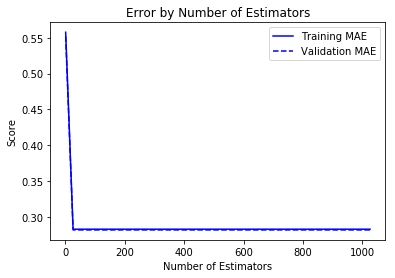

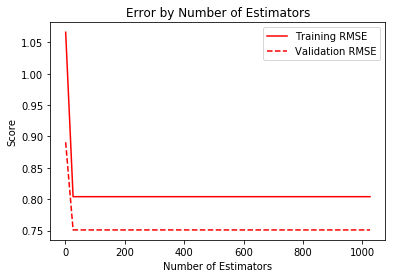

In [135]:
#graphs
plt.plot(estimators,train_MAE,label='Training MAE',linestyle='-',color='blue')
plt.plot(estimators,val_MAE,label='Validation MAE',linestyle='--',color='blue')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Error by Number of Estimators')
plt.legend()
plt.show();
plt.plot(estimators,train_RMSE,label='Training RMSE',linestyle='-',color='red')
plt.plot(estimators,val_RMSE,label='Validation RMSE',linestyle='--',color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Error by Number of Estimators')
plt.legend();

Looks like the best number of estimators is pretty low again.  It seems weird to be that low but I don't know what to do about it so I'm going to keep it high and vary the number of early stopping rounds again.

In [136]:
#Figure out best number of early stopping rounds
train_MAE=[]
val_MAE=[]
train_RMSE=[]
val_RMSE=[]
rounds=range(1,111,10)
for r in rounds:
    early_stopping_xgb_scaled=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000)
    early_stopping_xgb_scaled.fit(X_train_set,y_train_scaled,early_stopping_rounds=r,eval_set=eval_set_scaled,verbose=False)
    y_train_pred=early_stopping_xgb_scaled.predict(X_train_set)
    y_val_pred=early_stopping_xgb_scaled.predict(X_val_set)
    train_MAE.append(mean_absolute_error(y_train_pred, y_train_scaled))
    val_MAE.append(mean_absolute_error(y_val_pred, y_val_scaled))
    train_RMSE.append(np.sqrt(mean_squared_error(y_train_pred, y_train_scaled)))
    val_RMSE.append(np.sqrt(mean_squared_error(y_val_pred, y_val_scaled)))

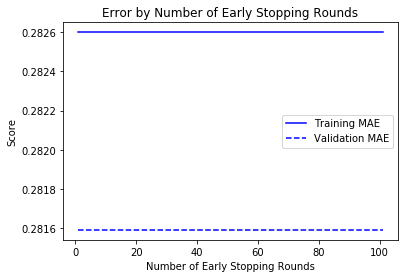

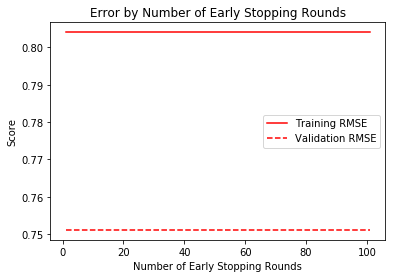

In [137]:
#graphs
plt.plot(rounds,train_MAE,label='Training MAE',linestyle='-',color='blue')
plt.plot(rounds,val_MAE,label='Validation MAE',linestyle='--',color='blue')
plt.xlabel('Number of Early Stopping Rounds')
plt.ylabel('Score')
plt.title('Error by Number of Early Stopping Rounds')
plt.legend()
plt.show();
plt.plot(rounds,train_RMSE,label='Training RMSE',linestyle='-',color='red')
plt.plot(rounds,val_RMSE,label='Validation RMSE',linestyle='--',color='red')
plt.xlabel('Number of Early Stopping Rounds')
plt.ylabel('Score')
plt.title('Error by Number of Early Stopping Rounds')
plt.legend();

So, again, it doesn't look like the number of early stopping rounds changes anything. Next, I'll rerun my gridsearch with the scaled outcome data.

In [138]:
#using a gridsearch to figure out best hyperparameters
xgb_searching_scaled=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000,early_stopping_rounds=5)
xgb_param_grid={'subsample':[0.5,1],'gamma':[0,5,10]}
grid_search_scaled=GridSearchCV(xgb_searching_scaled,xgb_param_grid,cv=3,return_train_score=True)
grid_search_scaled.fit(X_train_set,y_train_scaled)
training_score = np.mean(grid_search.cv_results_['mean_train_score'])
val_score = grid_search.score(X_val_set,y_val_scaled)
print(f"Mean Training Score: {training_score :.2%}")
print(f"Mean Validation Score: {val_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")

Mean Training Score: 89.74%
Mean Validation Score: -107918.37%
Best Parameter Combination Found During Grid Search:


In [139]:
#Finding the best parameters for the model
print(grid_search_scaled.best_params_)

{'gamma': 10, 'subsample': 0.5}


Now that I have the best parameters for my scaled outcome model, I'm going to run it one last time with those new parameters.

In [140]:
#the scaled model with the best parameters from the grid search
xgb_best_scaled=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000,
                                        early_stopping_rounds=10,gamma=10,subsample=0.5,tree_method='hist')
xgb_best_scaled.fit(X_train_set,y_train,eval_set=eval_set_scaled,verbose=False)
y_train_pred=xgb_best_scaled.predict(X_train_set)
y_val_pred=xgb_best_scaled.predict(X_val_set)
print(f'XGBoost Statistics\n')
print("Mean Absolute Error (Training Set): " + str(mean_absolute_error(y_train_pred, y_train_scaled)))
print("Mean Absolute Error (Validation Set): " + str(mean_absolute_error(y_val_pred, y_val_scaled)))
print("Root Mean Squared Error (Training Set): " + str(np.sqrt(mean_squared_error(y_train_pred, y_train_scaled))))
print("Root Mean Squared Error (Validation Set): " + str(np.sqrt(mean_squared_error(y_val_pred, y_val_scaled))))

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBoost Statistics

Mean Absolute Error (Training Set): 4.6784246458662855
Mean Absolute Error (Validation Set): 4.540055115351703
Root Mean Squared Error (Training Set): 32.102374135891814
Root Mean Squared Error (Validation Set): 25.91528606592456


In [141]:
#running the testing data throught the model
X_test_set=X_test[features]
y_test_pred=xgb_best_scaled.predict(X_test_set)
print("Mean Absolute Error (Test Set): " + str(mean_absolute_error(y_test_pred, y_test_scaled)))
print("Root Mean Squared Error (Test Set): " + str(np.sqrt(mean_squared_error(y_test_pred, y_test_scaled))))

Mean Absolute Error (Test Set): 5.18412886293861
Root Mean Squared Error (Test Set): 38.924513027824275


In [142]:
#Checking the model performance
exp_var_train=explained_variance_score(y_train_pred,y_train_scaled)
exp_var_val=explained_variance_score(y_val_pred,y_val_scaled)
exp_var_test=explained_variance_score(y_test_pred,y_test_scaled)
print('Explained Variance Scores')
print(f'Training: {exp_var_train}')
print(f'Validation: {exp_var_val}')
print(f'Testing: {exp_var_test}')

Explained Variance Scores
Training: 0.05655142277350289
Validation: 0.026983013281675294
Testing: 0.030150764098075156


Wow, that's terrible.  I'm going to use the unscaled outcome instead.

### Interpretation

Let's look at which features are most important when determining the price of Magic cards.

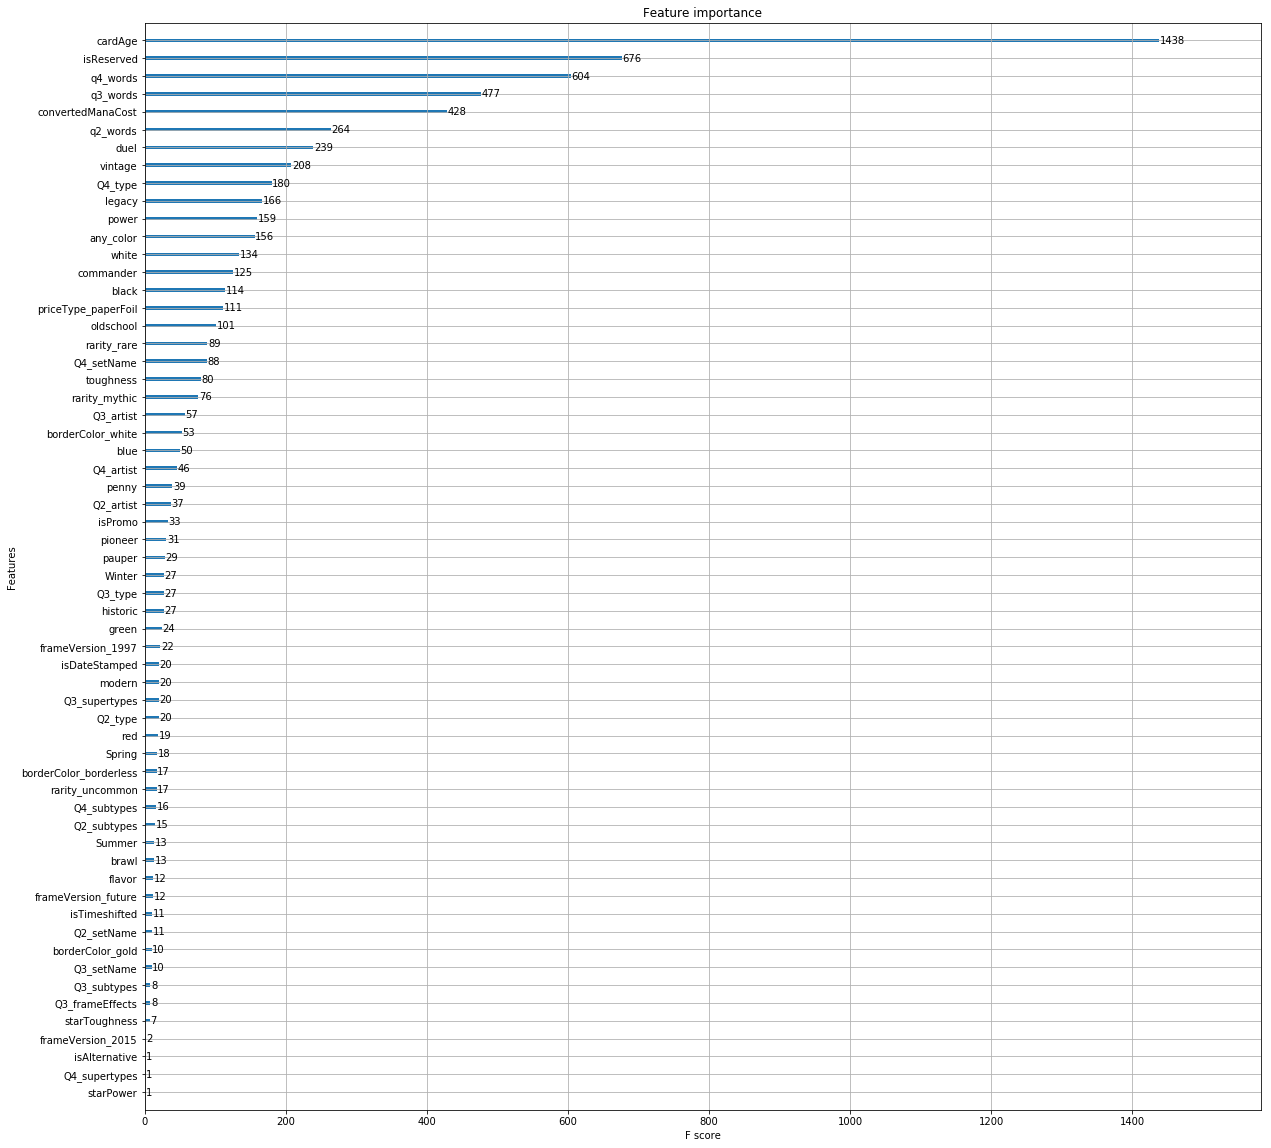

In [146]:
#plotting the most important predictors
xgb.plot_importance(xgb_best)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show();

As the graph shows, the card age is the most important predictor followed by the converted Mana cost.  I don't know if it's better to have older or younger cards or if the card should have a high or low mana cost so let's take a look at one of the trees in the model.

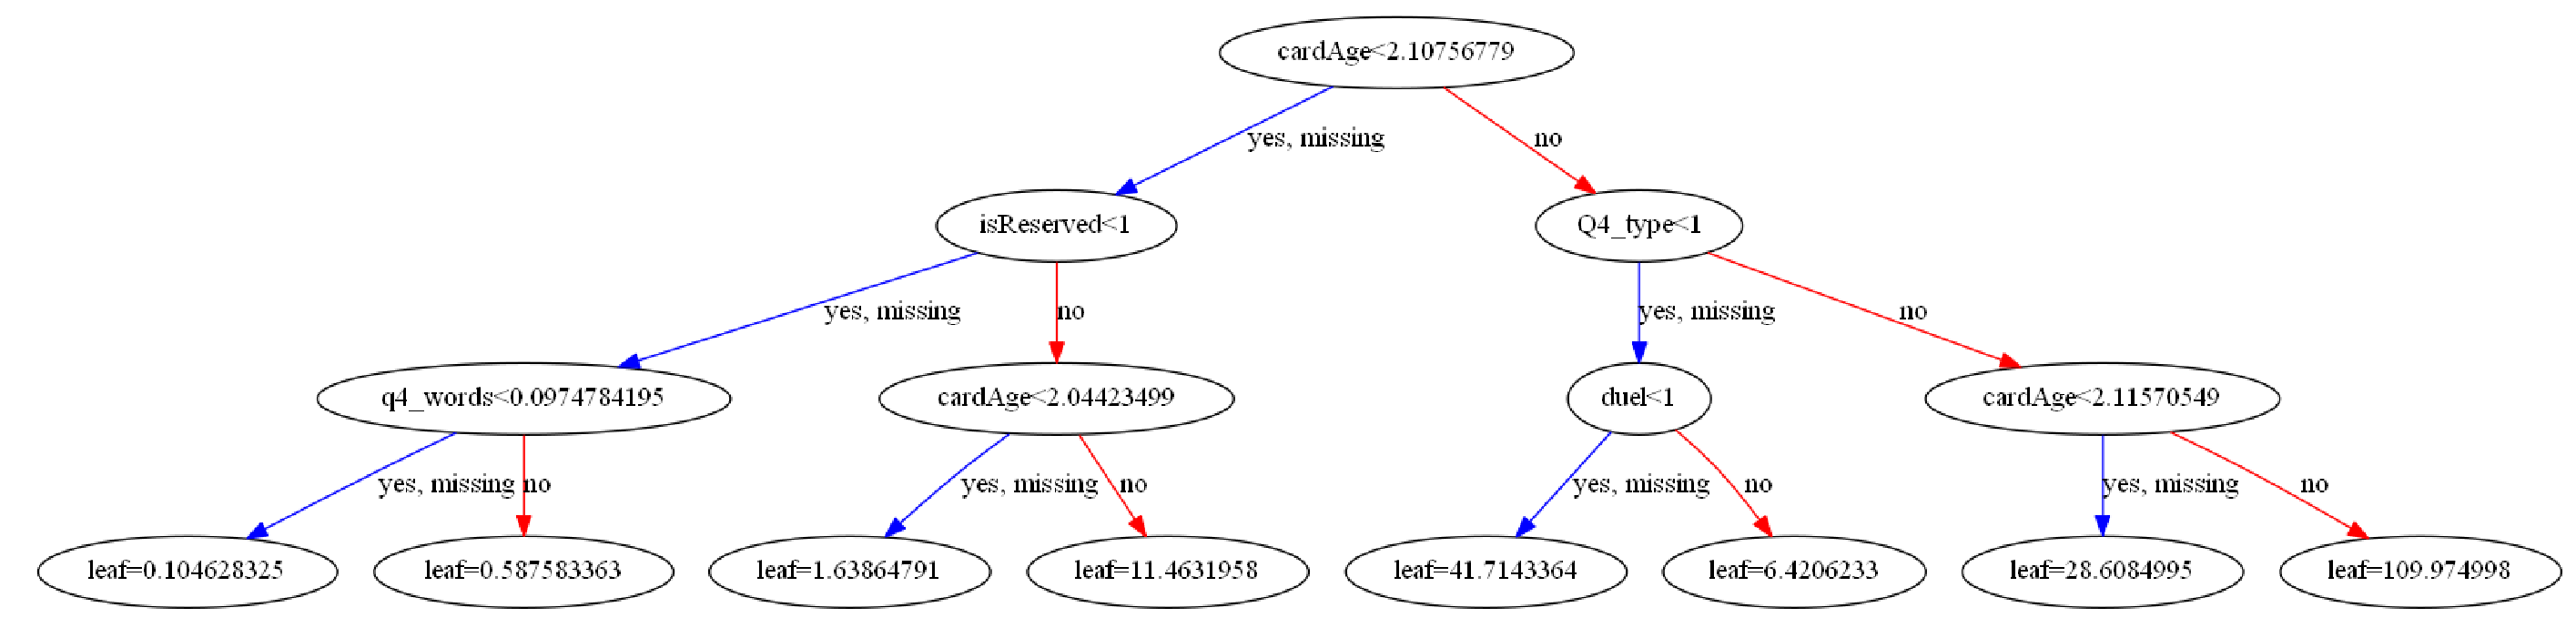

In [148]:
xgb.plot_tree(xgb_best,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 60]
plt.show();

It looks like the older cards are worth more.  Finally, let's predict which cards from the Ikoria set might be worth the most in a few months.  Only time will tell if the predictions end up being correct.

I'm going to take the Ikoria data through all of the same processing steps as my other data so that I can run it through the model.  At the end, I'll have it print out the cards that are predicted to be the most valuable.

In [149]:
#getting the data from the SQL database
conn = sqlite3.Connection('AllPrintings.sqlite')
c = conn.cursor()
c.execute("""SELECT c.uuid, c.name,c.names, c.artist, c.borderColor,
                    c.colors,c.convertedManaCost,c.flavorText,c.frameEffects,
                    c.frameVersion,c.isAlternative,c.isDateStamped,c.isFullArt,
                    c.isPromo,c.isReserved,c.isTimeShifted,c.layout,c.manaCost,
                    c.power,c.rarity,c.subtypes,c.supertypes,c.text,c.originalText,
                    c.toughness,c.type,c.types,s.name as setName,s.releaseDate,
                    l.format,l.status,p.date as priceDate,p.type as priceType,p.price
            FROM cards as c
            JOIN sets as s 
            ON s.code = c.setCode
            JOIN legalities as l
            on l.uuid = c.uuid
            JOIN prices as p
            ON p.uuid = c.uuid
            WHERE priceType='paper' or priceType='paperFoil'""")
all_df=pd.DataFrame(c.fetchall())
all_df.columns=[x[0] for x in c.description]

In [153]:
#separating the Ikoria cards
ikoria_df=all_df.loc[all_df.setName=='Ikoria: Lair of Behemoths'].copy()

In [154]:
#cleaning and processing the data to get it ready for the model
paper_ikoria=ikoria_df.loc[ikoria_df.priceType=="paper"].copy()
paper_formats_ikoria=paper_ikoria.pivot(index='uuid',columns='format',values='status')
ikoria_formats=paper_formats_ikoria.columns
for form in ikoria_formats:
    paper_formats_ikoria[form]=[1 if paper_formats_ikoria[form][x]=='Legal' else 0 for x in paper_formats_ikoria.index]
ikoria_df.drop(['format','status'],axis=1,inplace=True)
ikoria_df.drop_duplicates(keep='first', inplace=True)
ikoria_df=pd.merge(ikoria_df,paper_formats_ikoria,left_on='uuid',right_on='uuid')
weird_ikoria_cards=ikoria_df.loc[(ikoria_df.layout=='split')|(ikoria_df.layout=='aftermath')].index
for card in weird_ikoria_cards:
    ikoria_df.name[card]=ikoria_df.names[card]
ikoria_df.drop('names',axis=1,inplace=True)
ikoria_df['allText']=[ikoria_df.text[x] if ikoria_df.text[x]==ikoria_df.originalText[x] 
                     else (str(ikoria_df.text[x])+' '+str(ikoria_df.originalText[x])) for x in ikoria_df.index]
ikoria_df.drop(['text','originalText'],axis=1,inplace=True)
ikoria_df.releaseDate=pd.to_datetime(ikoria_df['releaseDate'])
ikoria_df.priceDate=pd.to_datetime(ikoria_df['priceDate'])
ikoria_df['cardAge']=ikoria_df['priceDate']-ikoria_df['releaseDate']
ikoria_df.cardAge=[x.days for x in ikoria_df.cardAge]
colors=[]
for card in ikoria_df.index:
    colors.append(colorCost(card))
colors_df=pd.DataFrame(colors,index=[x['card'] for x in colors])
colors_df.drop('card',axis=1,inplace=True)
ikoria_df=pd.merge(ikoria_df,colors_df,left_on=ikoria_df.index,right_on=colors_df.index)
cols_to_drop=['key_0','colors','manaCost','priceDate','card_name']
ikoria_df.drop(cols_to_drop,axis=1,inplace=True)
cols_to_encode=['borderColor','frameVersion','priceType','rarity']
ohe_df=pd.get_dummies(ikoria_df[cols_to_encode])
ikoria_df=pd.merge(ikoria_df,ohe_df,left_on=ikoria_df.index,right_on=ohe_df.index)
ikoria_df.drop(['key_0','borderColor','frameVersion','priceType','rarity'],axis=1,inplace=True)
ikoria_df['releaseSeason']=['Winter' if ikoria_df.releaseDate[x].month in [12,1,2]
                                     else 'Spring' if ikoria_df.releaseDate[x].month in [3,4,5]
                                     else 'Summer' if ikoria_df.releaseDate[x].month in [6,7,8]
                                     else 'Fall' if ikoria_df.releaseDate[x].month in [9,10,11]
                                     else 'None' for x in ikoria_df.index]
ikoria_df.drop('releaseDate',axis=1,inplace=True)
seasons=pd.get_dummies(ikoria_df['releaseSeason'])
ikoria_df=pd.merge(ikoria_df,seasons,left_on=ikoria_df.index,right_on=seasons.index)
ikoria_df.drop(['key_0','releaseSeason'],axis=1,inplace=True)
ikoria_df['flavor']=[1 if ikoria_df.flavorText[x] else 0 for x in ikoria_df.index]
ikoria_df.drop('flavorText',axis=1,inplace=True)
ikoria_df['starPower']=[1 if ikoria_df.power[x] in ['*','1+*','2+*']
                            else 0 for x in ikoria_df.index]
ikoria_df['starToughness']=[1 if ikoria_df.toughness[x] in ['*','1+*','2+*','7-*'] 
                                else 0 for x in ikoria_df.index]
ikoria_df['power']=[float(ikoria_df.power[x]) if ikoria_df.power[x] not in [None,'*','1+*','2+*']
                           else 1 if ikoria_df.power[x]=='1+*'
                           else 2 if ikoria_df.power[x]=='2+*'
                           else 0 for x in ikoria_df.index]
ikoria_df['toughness']=[float(ikoria_df.toughness[x]) if ikoria_df.toughness[x] not in [None,'*','1+*','2+*','7-*'] 
                               else 1 if ikoria_df.toughness[x]=='1+*'
                               else 2 if ikoria_df.toughness[x]=='2+*'
                               else 7 if ikoria_df.toughness[x]=='7-*'
                               else 0 for x in ikoria_df.index]
X_ikoria=ikoria_df.drop(['price'],axis=1)
y_ikoria=ikoria_df.price

ohe_features=['artist','frameEffects','layout','supertypes','type','subtypes','setName']
ohe_groups=[artist_groups,frame_effect_groups,layout_groups,supertype_groups,type_groups,subtype_groups,setName_groups]

X_ikoria=preprocess_ohe(ohe_features,ohe_groups,X_ikoria)
X_ikoria=preprocess_tokenize(X_ikoria)
X_ikoria[features_to_standardize]=scaler.transform(X_ikoria[features_to_standardize])

In [156]:
other_features=['frameVersion_future','Winter','borderColor_gold','Summer','Q4_layout','Q4_supertypes',
                'Q3_layout','Q2_supertypes','frameVersion_2003','Q2_layout','Q2_setName','oldschool', 
                'borderColor_white','frameVersion_1997','Q3_setName','Q4_setName']
for feature in other_features:
    X_ikoria[feature]=[0 for x in X_ikoria.index]

In [157]:
#Using the model to make predictions
ikoria_predictions_df=X_ikoria
ikoria_predictions_df['predicted_price']=xgb_best.predict(X_ikoria[features])
ikoria_predictions_df.head()

,uuid,name,artist,convertedManaCost,frameEffects,isAlternative,isDateStamped,isFullArt,isPromo,isReserved,...,Q2_supertypes,frameVersion_2003,Q2_layout,Q2_setName,oldschool,borderColor_white,frameVersion_1997,Q3_setName,Q4_setName,predicted_price
0,feee1087-df1d-51e9-ace0-7afbe81aca01,Adaptive Shimmerer,Jason Felix,1.049015,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.449371
1,feee1087-df1d-51e9-ace0-7afbe81aca01,Adaptive Shimmerer,Jason Felix,1.049015,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.720940
2,96965a95-5134-5d52-b05d-c3c20ba1eea3,Adventurous Impulse,Victor Adame Minguez,-1.058261,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.270872
3,96965a95-5134-5d52-b05d-c3c20ba1eea3,Adventurous Impulse,Victor Adame Minguez,-1.058261,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.657731
4,e668b7f0-3206-5e90-bcb2-b5210d908c9c,Aegis Turtle,Milivoj Ćeran,-1.058261,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.736483


In [158]:
#sorting the predictions by value
ikoria_predictions_df.sort_values(by=['predicted_price'],ascending=False).head(10)

,uuid,name,artist,convertedManaCost,frameEffects,isAlternative,isDateStamped,isFullArt,isPromo,isReserved,...,Q2_supertypes,frameVersion_2003,Q2_layout,Q2_setName,oldschool,borderColor_white,frameVersion_1997,Q3_setName,Q4_setName,predicted_price
549,043b2460-0892-5cb2-b81c-99a42e2d2fb7,Zagoth Triome,Robbie Trevino,-1.585080,showcase,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,34.669964
222,f7d58269-f37c-5268-b5c0-e6dddc6698e6,Indatha Triome,Robbie Trevino,-1.585080,showcase,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,34.636444
393,87a5fb06-7840-5984-b263-dd3e9635ccae,Raugrin Triome,Robbie Trevino,-1.585080,showcase,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,34.543633
421,a4ad1c97-fe3b-5917-b83e-0a5c20e06fc1,Savai Triome,Robbie Trevino,-1.585080,showcase,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,34.404995
255,6017deda-64bc-5310-8572-f1e1de2022d8,Ketria Triome,Robbie Trevino,-1.585080,showcase,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,34.315216
331,ebe1621b-93f1-5c13-ab62-9da14e5e5b91,Narset of the Ancient Way,Kev Walker,0.522196,None,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,31.666521
337,15ac0add-36a7-545d-9ccb-dea18aee9323,"Nethroi, Apex of Death",Tomasz Jedruszek,1.049015,"showcase,legendary",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,31.604418
512,8d948f7c-b053-50e9-bb7e-b87da4fd768b,"Vivien, Monsters' Advocate",Kev Walker,1.049015,None,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,30.494349
281,df5762bc-c295-5504-9161-8acdd09f7a52,"Lukka, Coppercoat Outcast",Kieran Yanner,1.049015,None,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,30.267923
175,e7dfe7af-850c-57af-965c-c31d592fb83d,Gemrazer,Andrew Huerta,0.522196,showcase,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,29.460474


In [159]:
#printing out the most valuable cards and some of their features
top_value_cards=[549,222,393,421,255,331,337,512,281]
important_columns=['name','frameEffects','isAlternative','isDateStamped','isFullArt','isPromo','isReserved',
       'isTimeshifted','layout','borderColor_black','borderColor_borderless','priceType_paper',
       'priceType_paperFoil','rarity_common','rarity_mythic','rarity_rare','rarity_uncommon']
for card in top_value_cards:
    for column in important_columns:
        if ikoria_predictions_df[column][card]!=0:
            print(f'{column}: {ikoria_predictions_df[column][card]}')
    print('\n')

name: Zagoth Triome
frameEffects: showcase
isPromo: 1
layout: normal
borderColor_borderless: 1
priceType_paperFoil: 1
rarity_rare: 1


name: Indatha Triome
frameEffects: showcase
isPromo: 1
layout: normal
borderColor_borderless: 1
priceType_paperFoil: 1
rarity_rare: 1


name: Raugrin Triome
frameEffects: showcase
isPromo: 1
layout: normal
borderColor_borderless: 1
priceType_paperFoil: 1
rarity_rare: 1


name: Savai Triome
frameEffects: showcase
isPromo: 1
layout: normal
borderColor_borderless: 1
priceType_paperFoil: 1
rarity_rare: 1


name: Ketria Triome
frameEffects: showcase
isPromo: 1
layout: normal
borderColor_borderless: 1
priceType_paperFoil: 1
rarity_rare: 1


name: Narset of the Ancient Way
frameEffects: None
isPromo: 1
layout: normal
borderColor_borderless: 1
priceType_paperFoil: 1
rarity_mythic: 1


name: Nethroi, Apex of Death
frameEffects: showcase,legendary
isPromo: 1
layout: normal
borderColor_borderless: 1
priceType_paperFoil: 1
rarity_mythic: 1


name: Vivien, Monsters'

According to my resident Magic expert: the Triomes are good and Lukka might be one of the top cards from the set.  It also makes sense for promos, foils, and mythic rare versions to be at the top of the list.

The weirdest card in this set of predictions is Nethroi, Apex of Death.  It's not completely unexpected but it's not one of the cards that currently has the highest value.

### Recommendations

If you're going to invest in cards, you should look primarily for older cards that have a higher converted Mana cost.  Having a lot of Q3 and Q4 words in the text is also important.  Cards also generally have higher prices if they're legal to play in a greater number of formats.

If you're looking to invest specifically in Ikoria Cards, the model recommends foil promo cards that have extended art and are mythic rares.

For future work (and to refine the model), I would also like to include data from tournaments because, I suspect, cards that are in tournament-winning decks are probably more valuable as well. I would also like to make a similar model but to predict a card's playability so that Magic players could quickly figure out which cards from a new set might be best for their competitive decks.

### References
- [MTGJSON](https://mtgjson.com/):  The source for data about Magic cards and their prices
- [Scryfall](https://scryfall.com/):  Images and additional information about Magic cards
- [Magic the Gathering](https://magic.wizards.com/en/game-info/gameplay/rules-and-formats/rules?source=MX_Nav2020):  Rules and glossary containing all of the special Magic words and phrases